In [ ]:
from google.colab import drive
drive.mount ("/content/drive")
import os
os.chdir ("/content/drive/MyDrive/")

Mounted at /content/drive


In [ ]:
from platform import python_version
print(python_version())

3.10.12


In [ ]:
windowday = 5   # How many days we want to predict the movement

In [ ]:
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score

import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
pd.set_option("display.max_columns", None)
pd.set_option('display.max_colwidth', None)
import warnings
warnings.filterwarnings('ignore')

import datetime as dt
from sklearn.cluster import KMeans
from itertools import zip_longest
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import TimeSeriesSplit

In [ ]:
# Implement the technical index function @Irene
window_size = 20
# This is KD (Stochastic Oscillator) index. Here I mimic powerful python TA_LIB which provides 158 technical index but the installation take long time
# fastk = (Closing price of the day - Lowest price in the past n days) ÷ (Highest price in the past n days - Lowest price in the past n days) × 100
# slowk = moving average of fastk = TA_LIB %K
# slowd = moving average of slowk = TA_LIB %D
# KD index consists of two values, K (fast line) and D (slow line), and uses three elements, the closing price, the highest price in a period of time and the lowest price,
# to measure the degree of change in the price of the stock deviating from the normal range, to determine the strength of the stock trend.

def calculate_stoch(high, low, close, fastk_period=14, slowk_period=3, slowd_period=3):
    highest_high = high.rolling(window=fastk_period).max()
    lowest_low = low.rolling(window=fastk_period).min()
    fastk = 100 * ((close - lowest_low) / (highest_high - lowest_low))
    slowk = fastk.rolling(window=slowk_period).mean()
    slowd = slowk.rolling(window=slowd_period).mean()
    return slowk, slowd

# This function calculates the Moving Average Convergence Divergence (MACD), which is a trend-following momentum indicator.
# macd_line = short EMA - long EMA where EMA stands for Exponential Moving Average.
# EMA (t) = a * closing price + (1-a) * EMA(t-1) so EMA shows in exponential form. Short/Long EMA differs in period, here short period 12, long period 26
# signal_line = moving average of macd_line, here we use 9-day for moving average
# macd_histogram =  macd_line - signal_line

def calculate_macd(close, short_window=12, long_window=26, signal_window=9):
    short_ema = close.ewm(span=short_window, min_periods=1, adjust=False).mean()
    long_ema = close.ewm(span=long_window, min_periods=1, adjust=False).mean()
    macd_line = short_ema - long_ema
    signal_line = macd_line.ewm(span=signal_window, min_periods=1, adjust=False).mean()
    macd_histogram = macd_line - signal_line
    return macd_line, signal_line, macd_histogram

# calculates Bollinger Bands, a type of statistical chart characterizing the prices and volatility over time
# middle_band calculates the simple moving average (SMA) of the closing prices over the specified window.
# upper_band/lower_band is middle_band +/- a specified number(here is 2) of standard deviations.

def calculate_bbands(close, window=20, num_std_dev=2):
    middle_band = close.rolling(window=window).mean()
    std_dev = close.rolling(window=window).std()
    upper_band = middle_band + (std_dev * num_std_dev)
    lower_band = middle_band - (std_dev * num_std_dev)
    return upper_band,middle_band,lower_band

# RSI (Relative Strength Index) is used for determining the strength of a stock (in our case BTC), and used for predict whether the stock price is likely to rise or fall in the future.
# It is the average price increase and average price decrease over a certain period of time.
# RSI formula: (a certain period of time) average rate of rise / (average rate of rise + average rate of fall)

def calculate_rsi(close, window=14):
    delta = close.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

In [ ]:
# Function to integrate technical index and set target @Irene
def movement(datain):
  data = datain[datain.columns]
  data['sma'] = data['Close'].rolling(window=window_size).mean()
  data['ema'] = data['Close'].ewm(span=window_size, adjust=False).mean()
  #data['slowk'], data['slowd'] = calculate_stoch(data['High'], data['Low'], data['Close'])
  data["macd"], data["macd_signal"], data["macd_hist"] = calculate_macd(data['Close'])
  #data["upper_band"], data["middle_band"], data["lower_band"] = calculate_bbands(data['Close'])
  data['rsi'] = calculate_rsi(data['Close'])
  data["nextClose"] = data.shift(-windowday)["Close"]

  # label +1/-1/0 for up/down/equal
  #data["target"] = np.where (data["nextClose"] - data["Close"] > windowday*50, 1, (np.where(data["nextClose"] - data["Close"] < -windowday*50, -1,0)))
  data["target"] = np.where (data["nextClose"] > data["Close"] * 1.0275, 1, (np.where(data["nextClose"] < data["Close"] * 0.9725, -1,0)))
  data.dropna(inplace=True)
  return data

In [ ]:
df_BTC = pd.read_csv("BTC-USD.csv", index_col = "Date")
# df0: BTC + technical index
df0 = movement(df_BTC)

df_fred = pd.read_csv("df_fred.csv", index_col = 0, parse_dates = True)
df_fred.index = pd.to_datetime(df_fred.index).strftime('%Y-%m-%d')
df1 = df0.merge(df_fred, left_index = True, right_index = True, how = "outer").ffill().bfill()

# Check distribution
df0_target1, df0_target2, df0_target3 = df0['target'].value_counts().reset_index(), df0.iloc[:-500]['target'].value_counts().reset_index(), df0[-500:]['target'].value_counts().reset_index()
df0_target1.columns, df0_target2.columns, df0_target3.columns = ['target', 'total'], ['target','use4TrainTest'], ['target', 'use4Froward']
df0_target1 = df0_target1.merge(df0_target2, how = "inner", on = "target")
df0_target1 = df0_target1.merge(df0_target3, how = "inner", on = "target")
display(df0_target1)

df_fred_extend = pd.read_csv("df_fred_extend.csv", index_col = 0, parse_dates = True)
df_fred_extend.index = pd.to_datetime(df_fred_extend.index).strftime('%Y-%m-%d')

,target,total,use4TrainTest,use4Froward
0,1,994,842,152
1,0,955,701,254
2,-1,735,641,94


extend want_to_search list and prepare data for unsupervised learning

In [ ]:
want_to_search_extend = ["SP500","NASDAQCOM","DJIA",
    "CP", "RSXFS","WM2NS", "GDP", "PCU325211325211", "PCE",
    "USACPALTT01CTGYM","UNRATE", "CGBD2534", "FEDFUNDS","GS10", "UMCSENT", "INDPRO", "HSN1F", "HOUST","PCU325325",
                "CPIAUCSL","MEDCPIM158SFRBCLE",'CPIAUCSL','MEDCPIM158SFRBCLE','CORESTICKM159SFRBATL','CPALTT01USM657N','STICKCPIM157SFRBATL','PPIACO','PCUOMFGOMFG'
                  ,'PCU325211325211','PCU325325','PPIFIS','DFF','REAINTRATREARAT10Y','MORTGAGE30US','A091RC1Q027SBEA','DGS2',
                 'GDPC1','T10YIE','WM2NS','M2REAL','UNRATE']
df_API=pd.concat([df_fred_extend[i] for i in want_to_search_extend],axis = 1) # Xinmei
df_API.index.name='Date'
df_API=df_API.reset_index()
df_extend=df0.merge(df_API,how='inner',on='Date')
df_extend=df0.merge(df_API,left_index = True, right_index = True, how = "outer")
#
#delete duplicate columns
df_extend = df_extend.loc[:,~df_extend.columns.duplicated()].copy()

In [ ]:
df2=df0.merge(df_API,how='inner',on='Date')

In [ ]:
# df_extend: BTC + technical index + FRED_extend @Irene
df_extend = df0.merge(df_fred_extend, left_index = True, right_index = True, how = "outer").ffill().bfill()

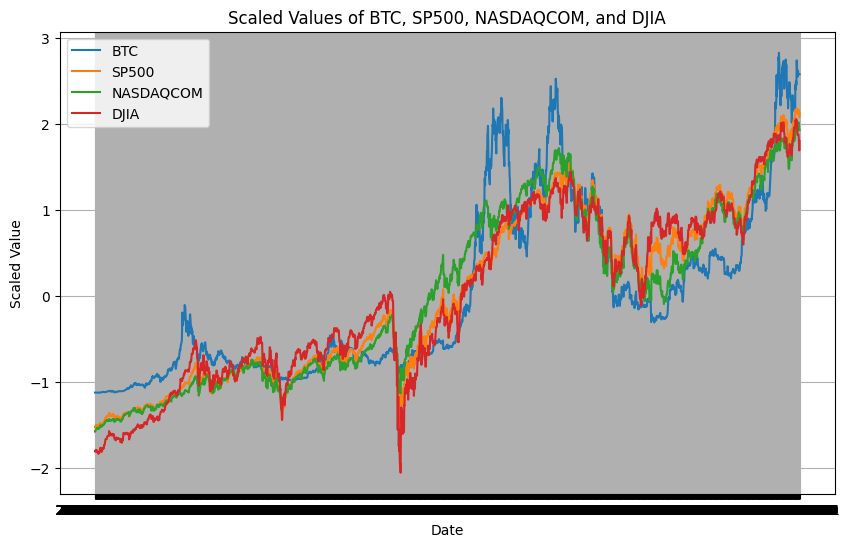

In [ ]:
# Show BTC has larger fluctuation than SP500, NASDAQ, DJIA @Irene
# Standard Scalar
scaler = StandardScaler()
temp = scaler.fit_transform(df1[["Close","SP500", "NASDAQCOM", "DJIA"]])
temp_scalar = pd.DataFrame(temp, index = df1.index, columns =["Close","SP500", "NASDAQCOM", "DJIA"] )
plt.figure(figsize=(10, 6))

plt.plot(temp_scalar.index, temp_scalar["Close"], label="BTC")
plt.plot(temp_scalar.index, temp_scalar["SP500"], label="SP500")
plt.plot(temp_scalar.index, temp_scalar["NASDAQCOM"], label="NASDAQCOM")
plt.plot(temp_scalar.index, temp_scalar["DJIA"], label="DJIA")

plt.xlabel('Date')
plt.ylabel('Scaled Value')
plt.title('Scaled Values of BTC, SP500, NASDAQCOM, and DJIA')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Feature and target extraction by Irene
def prepare_data(df):
    y = df["target"]
    X = df.drop(columns=["target", "nextClose"])
    return X, y

X0_full, y0_full = prepare_data(df0)
X1_full, y1_full = prepare_data(df1)
n_splits = 500
test_size = int(len(df0) * 0.2 / n_splits)
initial_train_size = len(df0)  - test_size * n_splits

X0, y0 = prepare_data(df0[:initial_train_size])
X1, y1 = prepare_data(df1[:initial_train_size])
X0_train, X0_test, y0_train, y0_test = train_test_split(X0, y0, test_size=0.2, random_state=42)
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

# Standardize data
scaler = StandardScaler()
X0_train_scaled = scaler.fit_transform(X0_train)
X0_test_scaled = scaler.transform(X0_test)
scaler = StandardScaler()
X1_train_scaled = scaler.fit_transform(X1_train)
X1_test_scaled = scaler.transform(X1_test)

In [ ]:
model = RandomForestClassifier(n_jobs=-1, random_state=42, max_features=None, max_depth = 20, min_samples_leaf = 1, min_samples_split = 2, n_estimators=200).fit(X1_train_scaled,y1_train)
y_pred = model.predict(X1_test_scaled)
accuracy_score(y1_test, y_pred),recall_score(y1_test, y_pred, average = "weighted"), f1_score(y1_test, y_pred, average = "weighted"), confusion_matrix(y1_test, y_pred)

(0.7185354691075515,
 0.7185354691075515,
 0.7174683009165344,
 array([[ 99,  20,  12],
        [ 24,  81,  30],
        [  9,  28, 134]]))

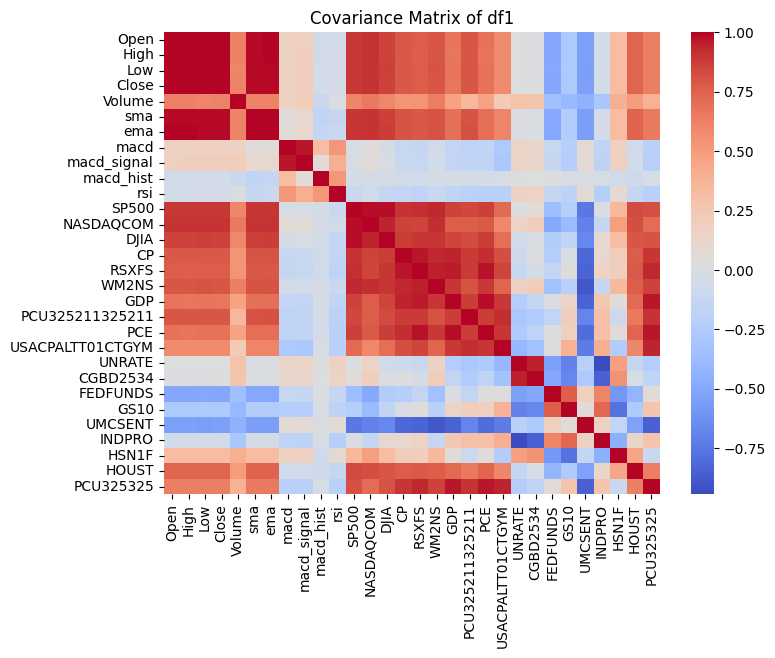

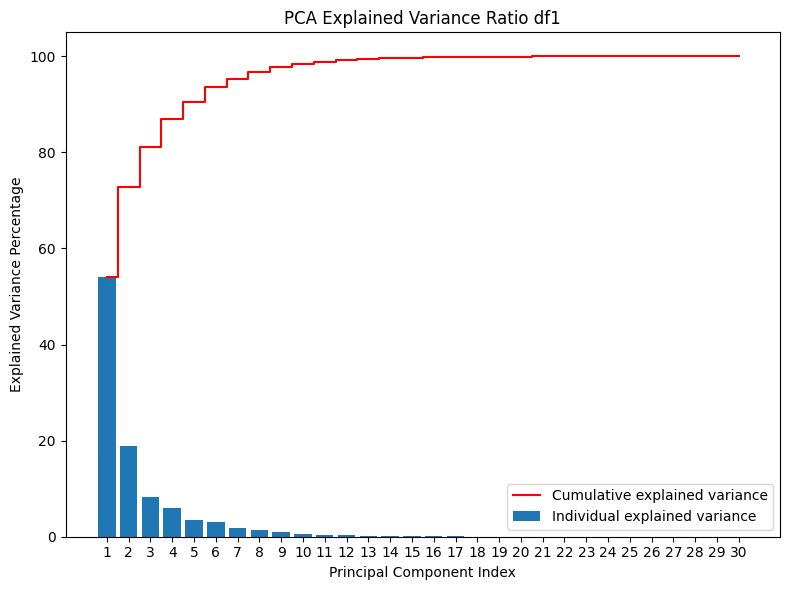

Number of components to explain 95% of the variance: 7


In [ ]:
# Calculate & plot covariance matrix for df1
cov_mat = np.cov(X1_train_scaled.T)
plt.figure(figsize=(8, 6))
sns.heatmap(cov_mat, cbar=True, cmap='coolwarm', xticklabels=X1_train.columns, yticklabels=X1_train.columns)
plt.title('Covariance Matrix of df1')
plt.show()

# Perform PCA on training data
pca = PCA()
_ = pca.fit(X1_train_scaled)

# Calculate explained variance ratios
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Plot individual and cumulative explained variance
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio * 100, align='center', label='Individual explained variance')
plt.step(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance * 100, where='mid', label='Cumulative explained variance', color='red')
plt.ylabel('Explained Variance Percentage')
plt.xlabel('Principal Component Index')
plt.title('PCA Explained Variance Ratio df1')
plt.xticks(ticks=list(range(1, len(explained_variance_ratio) + 1)))
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# Determine number of components to reach 95% explained variance
n_components_95 = np.argmax(cumulative_explained_variance >= 0.95) + 1
print(f'Number of components to explain 95% of the variance: {n_components_95}')

In [ ]:
# Define models with default settings by Irene
models = {
    'RandomForest': RandomForestClassifier(n_jobs=-1, random_state=42, oob_score=True, bootstrap = True),
    'KNN': KNeighborsClassifier(n_jobs=-1),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'SVM': SVC(random_state=42, kernel = 'rbf'),
    'NaiveBayes': GaussianNB(),
    'LogisticRegression': LogisticRegression(n_jobs=-1, random_state=42, multi_class='multinomial', max_iter=500,),
}

# Define parameter grids for each model
param_grids = {
    'RandomForest': {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
    },
    'KNN': {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance'],
        'p': [1, 2]
    },
    'DecisionTree': {
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
        'criterion': ['gini', 'entropy']
    },
    'SVM': {
        'C': [0.1, 1, 10, 100],
        'gamma': [0.001, 0.01, 0.1, 1],
        'kernel': [ 'rbf']
    },
    'NaiveBayes': {
        'var_smoothing': np.logspace(0, -9, num=10)
    },
    'LogisticRegression': {
        'C': [0.1, 1, 10],
    },
}

In [ ]:
def train_models_with_grid_search(X_train, y_train): #Irene
    results, best_estimators = [], {}
    for modelname, model in models.items():
        try:
            print(f'GridSearch on {modelname}')
            grid_search = GridSearchCV(model, param_grids[modelname], cv=5, scoring='accuracy', n_jobs=-1, return_train_score=True)
            grid_search.fit(X_train, y_train)
            best_estimators[modelname] = grid_search.best_estimator_
            cv_results = grid_search.cv_results_
            results.append({
                'Model': modelname,
                'Best Parameters': grid_search.best_params_,
                'Mean Train Score': np.mean(cv_results['mean_train_score']),
                'Mean Test Score': np.mean(cv_results['mean_test_score']),
                'Std Test Score': np.std(cv_results['mean_test_score']),
                'Best Test Score': grid_search.best_score_
            })
        except ValueError as e:
            print(f"Error with {modelname}: {e}")
    return best_estimators, pd.DataFrame(results)

In [ ]:
# Train models with grid search on df0.0.9725,1.0275 @Irene
print("Training on df0")
best_models_df0, grid_results_df0 = train_models_with_grid_search(X0_train_scaled, y0_train)
grid_results_df0

Training on df0
GridSearch on RandomForest
GridSearch on KNN
GridSearch on DecisionTree
GridSearch on SVM
GridSearch on NaiveBayes
GridSearch on LogisticRegression


,Model,Best Parameters,Mean Train Score,Mean Test Score,Std Test Score,Best Test Score
0,RandomForest,"{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}",0.974092,0.610298,0.014163,0.629688
1,KNN,"{'n_neighbors': 5, 'p': 1, 'weights': 'distance'}",0.853261,0.539332,0.037253,0.591900
2,DecisionTree,"{'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5}",0.879056,0.528311,0.022237,0.559820
3,SVM,"{'C': 100, 'gamma': 1, 'kernel': 'rbf'}",0.508989,0.440766,0.059583,0.575286
4,NaiveBayes,{'var_smoothing': 0.01},0.406397,0.397735,0.001574,0.398995
5,LogisticRegression,{'C': 10},0.419674,0.409090,0.007851,0.420174


In [ ]:
# Train models with grid search on df1.0.9725,1.0275 @Irene
print("Training on df1")
best_models_df1, grid_results_df1 = train_models_with_grid_search(X1_train_scaled, y1_train)
grid_results_df1

Training on df1
GridSearch on RandomForest
GridSearch on KNN
GridSearch on DecisionTree
GridSearch on SVM
GridSearch on NaiveBayes
GridSearch on LogisticRegression


,Model,Best Parameters,Mean Train Score,Mean Test Score,Std Test Score,Best Test Score
0,RandomForest,"{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}",0.958196,0.659097,0.016573,0.682327
1,KNN,"{'n_neighbors': 3, 'p': 1, 'weights': 'distance'}",0.868632,0.585081,0.040980,0.650287
2,DecisionTree,"{'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}",0.891414,0.583904,0.023175,0.616499
3,SVM,"{'C': 10, 'gamma': 1, 'kernel': 'rbf'}",0.580612,0.483944,0.084542,0.625659
4,NaiveBayes,{'var_smoothing': 0.0001},0.408830,0.402981,0.002260,0.404126
5,LogisticRegression,{'C': 10},0.480728,0.444760,0.008107,0.453344


In [ ]:
# Train models with grid search on df1.0.9725,1.0275, pca @Irene
print("Training on df1 pca")
pca = PCA(n_components=0.95)
X1_train_pca = pca.fit_transform(X1_train_scaled)
X1_test_pca = pca.transform(X1_test_scaled)
X1_train_scaled, X1_test_scaled = X1_train_pca, X1_test_pca
best_models_df1, grid_results_df1 = train_models_with_grid_search(X1_train_scaled, y1_train)
grid_results_df1

Training on df1 pca
GridSearch on RandomForest
GridSearch on KNN
GridSearch on DecisionTree
GridSearch on SVM
GridSearch on NaiveBayes
GridSearch on LogisticRegression


,Model,Best Parameters,Mean Train Score,Mean Test Score,Std Test Score,Best Test Score
0,RandomForest,"{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}",0.959353,0.590415,0.007335,0.602179
1,KNN,"{'n_neighbors': 5, 'p': 2, 'weights': 'distance'}",0.861227,0.561320,0.033193,0.599913
2,DecisionTree,"{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}",0.890742,0.525061,0.011866,0.554672
3,SVM,"{'C': 100, 'gamma': 1, 'kernel': 'rbf'}",0.548235,0.471525,0.075329,0.609626
4,NaiveBayes,{'var_smoothing': 0.001},0.430523,0.419059,0.006615,0.423009
5,LogisticRegression,{'C': 1},0.414856,0.393625,0.000269,0.393816


In [ ]:
# Define models with the best parameters found from grid search @Irene
best_models_df0 = {
    'RandomForest': RandomForestClassifier(n_jobs=-1, random_state=42, max_features=None, max_depth = None, min_samples_leaf = 1, min_samples_split = 2, n_estimators=200),
    'KNN': KNeighborsClassifier(n_jobs=-1, n_neighbors=5, p = 1, weights = 'distance'),
    'DecisionTree': DecisionTreeClassifier(random_state=42, max_depth=20, min_samples_leaf = 1, min_samples_split = 5, criterion = "gini"),
    'SVM': SVC(random_state=42, C=100, gamma=1, kernel = 'rbf'),
    'NaiveBayes': GaussianNB(var_smoothing = 0.01),
    'LogisticRegression': LogisticRegression(n_jobs=-1, random_state=42, multi_class='multinomial', solver='lbfgs', C=10, max_iter=500),
}

best_models_df1 = {
    'RandomForest': RandomForestClassifier(n_jobs=-1, random_state=42, max_features=None, max_depth = 20, min_samples_leaf = 1, min_samples_split = 2, n_estimators=200),
    'KNN': KNeighborsClassifier(n_jobs=-1, n_neighbors=3, p = 1, weights = 'distance'),
    'DecisionTree': DecisionTreeClassifier(random_state=42, max_depth=20, min_samples_leaf = 1, min_samples_split = 2, criterion = "gini"),
    'SVM': SVC(random_state=42, C=10, gamma=1, kernel = 'rbf'),
    'NaiveBayes': GaussianNB(var_smoothing = 0.0001),
    'LogisticRegression': LogisticRegression(n_jobs=-1, random_state=42, multi_class='multinomial', solver='lbfgs', C=10, max_iter=500),
}

best_models_df1_pca = {
    'RandomForest': RandomForestClassifier(n_jobs=-1, random_state=42, max_features=None, max_depth = None, min_samples_leaf = 1, min_samples_split = 2, n_estimators=200),
    'KNN': KNeighborsClassifier(n_jobs=-1, n_neighbors=5, p = 2, weights = 'distance'),
    'DecisionTree': DecisionTreeClassifier(random_state=42, max_depth=None, min_samples_leaf = 1, min_samples_split = 2, criterion = "entropy"),
    'SVM': SVC(random_state=42, C=100, gamma=1, kernel = 'rbf'),
    'NaiveBayes': GaussianNB(var_smoothing = 0.001),
    'LogisticRegression': LogisticRegression(n_jobs=-1, random_state=42, multi_class='multinomial', solver='lbfgs', C=1, max_iter=500),
}

In [ ]:
# Function to calculate and plot permutation importance
def get_permutation_importance(model, X_train, y_train, X_test, y_test, feature_names):
    model.fit(X_train,y_train)
    result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': result.importances_mean,
        'std': result.importances_std
    }).sort_values(by='importance', ascending=False)
    return importance_df

Getting feature importance for df0


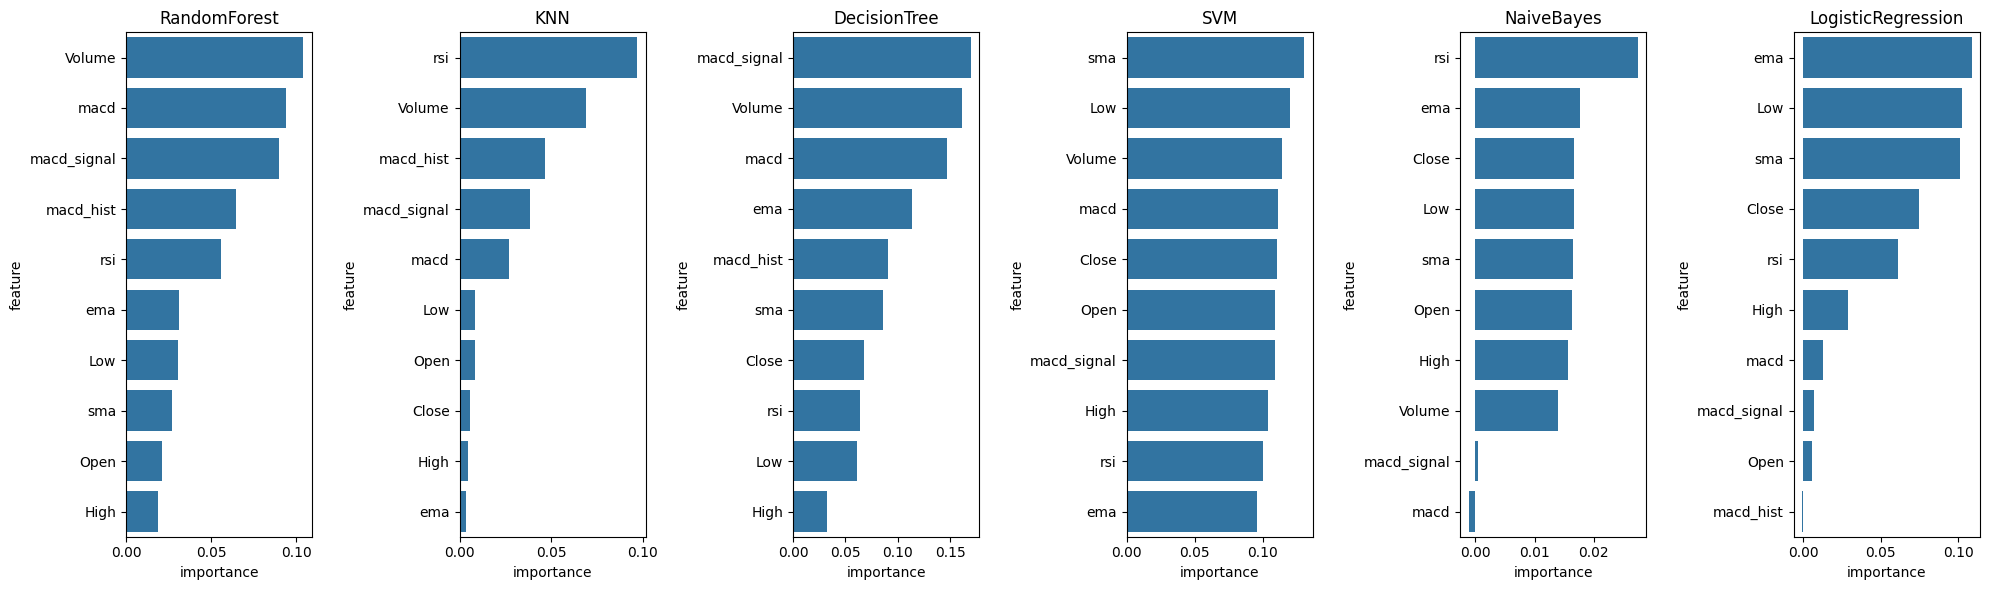

In [ ]:
print("Getting feature importance for df0")
fig, axes = plt.subplots(1,6, figsize=(20,6))
axes = axes.flatten()

for i, (modelname, model) in enumerate(best_models_df0.items()):
    importance_df = get_permutation_importance(model, X0_train_scaled, y0_train, X0_test_scaled, y0_test, X0.columns)
    top_10_features = importance_df.head(10)
    sns.barplot(x='importance', y='feature', data=top_10_features, ax=axes[i])
    axes[i].set_title(f'{modelname}')

plt.tight_layout()
plt.show()

Getting feature importance for df1


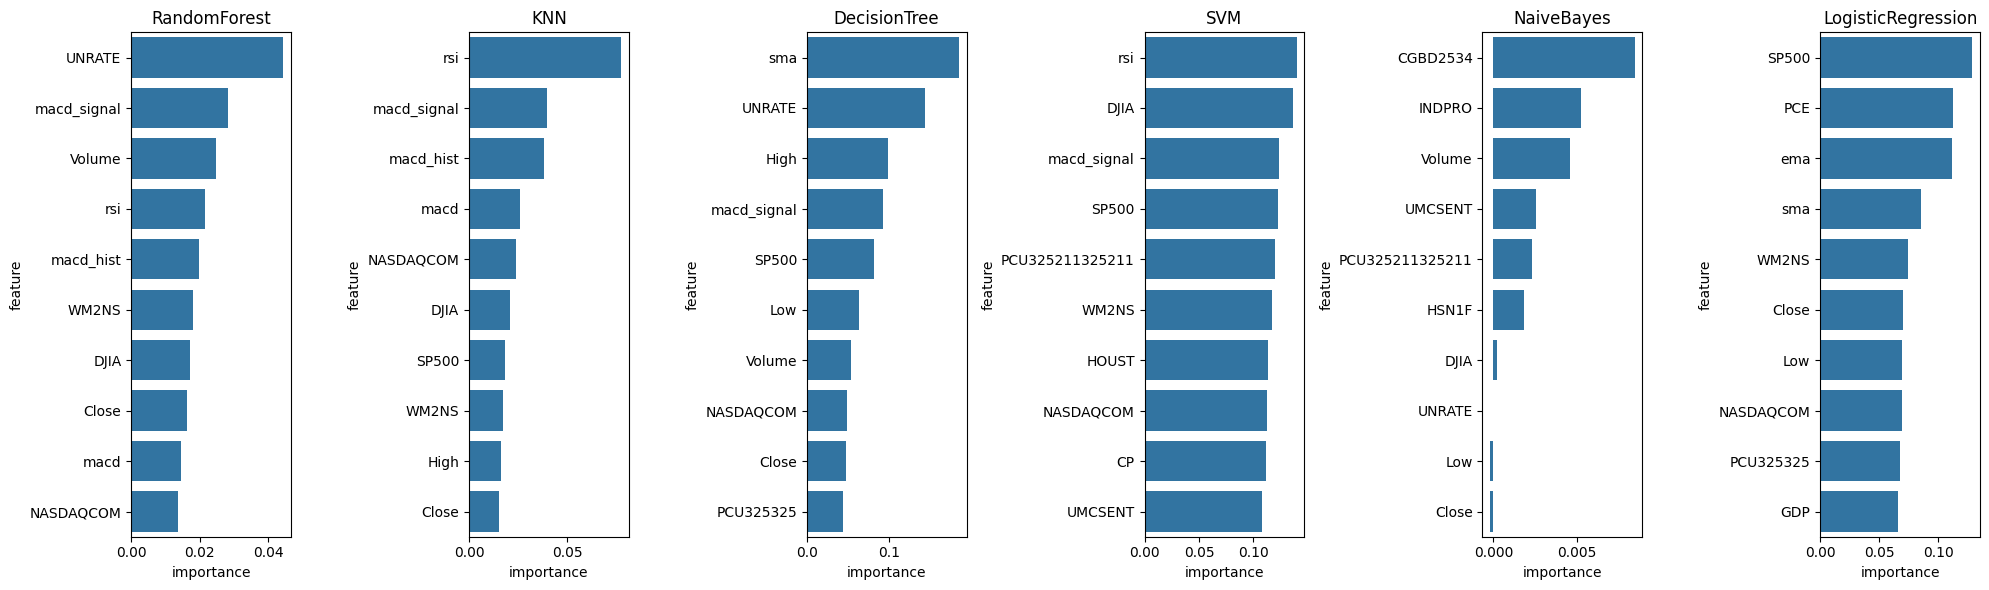

In [ ]:
print("Getting feature importance for df1")
# redefine X1_train_scaled &  X1_test_scaled due to they have been modified in pca tramsform previously
scaler = StandardScaler()
X1_train_scaled = scaler.fit_transform(X1_train)
X1_test_scaled = scaler.transform(X1_test)
fig, axes = plt.subplots(1,6, figsize=(20,6))
axes = axes.flatten()

for i, (modelname, model) in enumerate(best_models_df1.items()):
    importance_df = get_permutation_importance(model, X1_train_scaled, y1_train, X1_test_scaled, y1_test, X1.columns)
    top_10_features = importance_df.head(10)
    sns.barplot(x='importance', y='feature', data=top_10_features, ax=axes[i])
    axes[i].set_title(f'{modelname}')

plt.tight_layout()
plt.show()

,PC,Most_Important_Feature,Variance_Ratio,Importance,Combined_Importance
0,PC1,SP500,0.540,0.243,0.131
1,PC2,GS10,0.188,0.377,0.071
2,PC3,macd,0.082,0.502,0.041
3,PC4,macd_hist,0.060,0.458,0.027
4,PC5,macd_hist,0.036,0.578,0.021
5,PC6,HSN1F,0.030,0.555,0.017
6,PC7,Volume,0.017,0.779,0.014


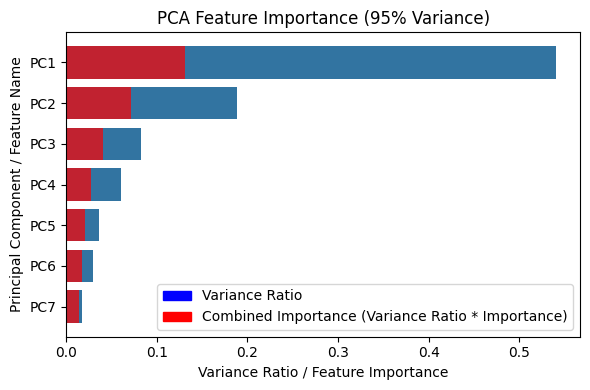

In [ ]:
# Calculate PCA feature importance
n_pcs = pca.components_.shape[0]
explained_variance_ratio = pca.explained_variance_ratio_
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]
initial_feature_names = X1.columns
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]
importance_values = [np.abs(pca.components_[i][most_important[i]]) for i in range(n_pcs)]
combined_importance = [explained_variance_ratio[i] * importance_values[i] for i in range(n_pcs)]
labels = ['PC{}'.format(i + 1, ) for i in range(n_pcs)]

# Create DataFrame
dic = {
    'PC': labels,
    'Most_Important_Feature': most_important_names,
    'Variance_Ratio': np.round(explained_variance_ratio, 3),
    'Importance': np.round(importance_values, 3),
    'Combined_Importance': np.round(combined_importance, 3)
}
pca_feature_importance_df = pd.DataFrame(dic).sort_values(by='Variance_Ratio', ascending=False)
display(pca_feature_importance_df)

fig, ax1 = plt.subplots(figsize=(6,4))
bars = sns.barplot(x='Variance_Ratio', y='PC', data=pca_feature_importance_df, ax=ax1)
for index, row in pca_feature_importance_df.iterrows():
    ax1.barh(y=row['PC'], width=row['Combined_Importance'], color='red', alpha=0.7)

ax1.set_title('PCA Feature Importance (95% Variance)')
ax1.set_xlabel('Variance Ratio / Feature Importance')
ax1.set_ylabel('Principal Component / Feature Name')

from matplotlib.patches import Patch
blue_patch = Patch(color='blue', label='Variance Ratio')
red_patch = Patch(color='red', label='Combined Importance (Variance Ratio * Importance)')
plt.legend(handles=[blue_patch, red_patch], loc='best')

plt.tight_layout()
plt.show()

In [ ]:
def model_fit(X, y, best_models, pca_flag, df_name):
  results = []
  for modelname, model in best_models_df0.items():
    try:
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
      scaler = StandardScaler()
      X_train_scaled = scaler.fit_transform(X_train)
      X_test_scaled = scaler.transform(X_test)
      if pca_flag:
            pca = PCA(n_components=0.95)
            X_train_pca = pca.fit_transform(X_train_scaled)
            X_test_pca = pca.transform(X_test_scaled)
            X_train_scaled, X_test_scaled = X_train_pca, X_test_pca
      print(f"{df_name} {modelname}")
      model.fit(X_train_scaled, y_train)
      y_pred = model.predict(X_test_scaled)
      results.append({
            'model': modelname,
            'ConfusionMatrix': confusion_matrix(y_test, y_pred),
            'Accuracy': accuracy_score(y_test, y_pred),
            'f1_score': f1_score(y_test, y_pred, average="weighted"),
            "recall": recall_score(y_test, y_pred, average="weighted"),
            "precision": precision_score(y_test, y_pred, average="weighted"),
            })
    except ValueError as e:
            print(f"Error with {modelname}: {e}")
  return pd.DataFrame(results)

print("Training on df0"); fit_results_df0 = model_fit(X0, y0, best_models_df0, False, "df0"); display(fit_results_df0)
print("Training on df1"); fit_results_df1 = model_fit(X1, y1, best_models_df1, False, "df1"); display(fit_results_df1)
print("Training on df1 PCA"); fit_results_df1_pca = model_fit(X1, y1, best_models_df1, True, "df1"); display(fit_results_df1_pca)

Training on df0
df0 RandomForest
df0 KNN
df0 DecisionTree
df0 SVM
df0 NaiveBayes
df0 LogisticRegression


,model,ConfusionMatrix,Accuracy,f1_score,recall,precision
0,RandomForest,"[[87, 29, 8], [23, 85, 34], [12, 30, 129]]",0.688787,0.689046,0.688787,0.689349
1,KNN,"[[76, 33, 15], [28, 77, 37], [19, 40, 112]]",0.606407,0.607639,0.606407,0.609363
2,DecisionTree,"[[78, 27, 19], [35, 78, 29], [28, 33, 110]]",0.608696,0.609741,0.608696,0.613060
3,SVM,"[[66, 32, 26], [27, 77, 38], [27, 48, 96]]",0.546911,0.547848,0.546911,0.550214
4,NaiveBayes,"[[38, 56, 30], [39, 70, 33], [37, 65, 69]]",0.405034,0.405441,0.405034,0.418219
5,LogisticRegression,"[[17, 40, 67], [15, 59, 68], [21, 38, 112]]",0.430206,0.401631,0.430206,0.408387


Training on df1
df1 RandomForest
df1 KNN
df1 DecisionTree
df1 SVM
df1 NaiveBayes
df1 LogisticRegression


,model,ConfusionMatrix,Accuracy,f1_score,recall,precision
0,RandomForest,"[[99, 20, 12], [24, 81, 30], [9, 30, 132]]",0.713959,0.713258,0.713959,0.712694
1,KNN,"[[98, 22, 11], [26, 80, 29], [18, 27, 126]]",0.695652,0.695055,0.695652,0.695480
2,DecisionTree,"[[87, 31, 13], [41, 62, 32], [16, 40, 115]]",0.604119,0.604512,0.604119,0.606372
3,SVM,"[[93, 25, 13], [30, 78, 27], [12, 38, 121]]",0.668192,0.669452,0.668192,0.671489
4,NaiveBayes,"[[46, 6, 79], [30, 21, 84], [37, 10, 124]]",0.437071,0.400349,0.437071,0.466432
5,LogisticRegression,"[[52, 29, 50], [39, 48, 48], [38, 31, 102]]",0.462243,0.457117,0.462243,0.457703


Training on df1 PCA
df1 RandomForest
df1 KNN
df1 DecisionTree
df1 SVM
df1 NaiveBayes
df1 LogisticRegression


,model,ConfusionMatrix,Accuracy,f1_score,recall,precision
0,RandomForest,"[[90, 25, 16], [27, 77, 31], [14, 38, 119]]",0.654462,0.655299,0.654462,0.656371
1,KNN,"[[89, 25, 17], [26, 77, 32], [20, 32, 119]]",0.652174,0.652176,0.652174,0.652317
2,DecisionTree,"[[86, 31, 14], [26, 78, 31], [29, 44, 98]]",0.599542,0.601149,0.599542,0.608497
3,SVM,"[[89, 23, 19], [28, 74, 33], [10, 38, 123]]",0.654462,0.654366,0.654462,0.654443
4,NaiveBayes,"[[43, 26, 62], [37, 52, 46], [39, 32, 100]]",0.446224,0.440750,0.446224,0.442485
5,LogisticRegression,"[[20, 20, 91], [7, 39, 89], [17, 27, 127]]",0.425629,0.385483,0.425629,0.438228


In [ ]:
def model_fit(X, y, best_models, pca_flag, df_name):
  results = []
  for modelname, model in best_models_df0.items():
    try:
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
      scaler = StandardScaler()
      X_train_scaled = scaler.fit_transform(X_train)
      X_test_scaled = scaler.transform(X_test)
      if pca_flag:
            pca = PCA(n_components=0.95)
            X_train_pca = pca.fit_transform(X_train_scaled)
            X_test_pca = pca.transform(X_test_scaled)
            X_train_scaled, X_test_scaled = X_train_pca, X_test_pca
      print(f"{df_name} {modelname}")
      model.fit(X_train_scaled, y_train)
      y_pred = model.predict(X_test_scaled)
      results.append({
            'model': modelname,
            'ConfusionMatrix': confusion_matrix(y_test, y_pred),
            'Accuracy': accuracy_score(y_test, y_pred),
            'f1_score': f1_score(y_test, y_pred, average="weighted"),
            })
    except ValueError as e:
            print(f"Error with {modelname}: {e}")
  return pd.DataFrame(results)

print("Training on df0"); fit_results_df0 = model_fit(X0, y0, best_models_df0, False, "df0"); display(fit_results_df0)
print("Training on df1"); fit_results_df1 = model_fit(X1, y1, best_models_df1, False, "df1"); display(fit_results_df1)
print("Training on df1 PCA"); fit_results_df1_pca = model_fit(X1, y1, best_models_df1, True, "df1"); display(fit_results_df1_pca)

Training on df0
df0 RandomForest
df0 KNN
df0 DecisionTree
df0 SVM
df0 NaiveBayes
df0 LogisticRegression


,model,ConfusionMatrix,Accuracy,f1_score
0,RandomForest,"[[87, 29, 8], [23, 85, 34], [12, 30, 129]]",0.688787,0.689046
1,KNN,"[[76, 33, 15], [28, 77, 37], [19, 40, 112]]",0.606407,0.607639
2,DecisionTree,"[[78, 27, 19], [35, 78, 29], [28, 33, 110]]",0.608696,0.609741
3,SVM,"[[66, 32, 26], [27, 77, 38], [27, 48, 96]]",0.546911,0.547848
4,NaiveBayes,"[[38, 56, 30], [39, 70, 33], [37, 65, 69]]",0.405034,0.405441
5,LogisticRegression,"[[17, 40, 67], [15, 59, 68], [21, 38, 112]]",0.430206,0.401631


Training on df1
df1 RandomForest
df1 KNN
df1 DecisionTree
df1 SVM
df1 NaiveBayes
df1 LogisticRegression


,model,ConfusionMatrix,Accuracy,f1_score
0,RandomForest,"[[99, 20, 12], [24, 81, 30], [9, 30, 132]]",0.713959,0.713258
1,KNN,"[[98, 22, 11], [26, 80, 29], [18, 27, 126]]",0.695652,0.695055
2,DecisionTree,"[[87, 31, 13], [41, 62, 32], [16, 40, 115]]",0.604119,0.604512
3,SVM,"[[93, 25, 13], [30, 78, 27], [12, 38, 121]]",0.668192,0.669452
4,NaiveBayes,"[[46, 6, 79], [30, 21, 84], [37, 10, 124]]",0.437071,0.400349
5,LogisticRegression,"[[52, 29, 50], [39, 48, 48], [38, 31, 102]]",0.462243,0.457117


Training on df1 PCA
df1 RandomForest
df1 KNN
df1 DecisionTree
df1 SVM
df1 NaiveBayes
df1 LogisticRegression


,model,ConfusionMatrix,Accuracy,f1_score
0,RandomForest,"[[90, 25, 16], [27, 77, 31], [14, 38, 119]]",0.654462,0.655299
1,KNN,"[[89, 25, 17], [26, 77, 32], [20, 32, 119]]",0.652174,0.652176
2,DecisionTree,"[[86, 31, 14], [26, 78, 31], [29, 44, 98]]",0.599542,0.601149
3,SVM,"[[89, 23, 19], [28, 74, 33], [10, 38, 123]]",0.654462,0.654366
4,NaiveBayes,"[[43, 26, 62], [37, 52, 46], [39, 32, 100]]",0.446224,0.440750
5,LogisticRegression,"[[20, 20, 91], [7, 39, 89], [17, 27, 127]]",0.425629,0.385483


In [ ]:
# Model fit on whole dataset - all of all, day by day
def walk_forward_validation(X, y, best_models, pca_flag, df_name, df):
  results, forward_result = [], {}
  for modelname, model in best_models.items():
    print (f'Model: {modelname}')
    tscv = TimeSeriesSplit(n_splits=n_splits)
    y_true, y_pred = [], []
    for i in range(n_splits):
        train_end = initial_train_size + i * test_size
        test_end = train_end + test_size
        X_train, X_test, y_train, y_test = X.iloc[:train_end], X.iloc[train_end:test_end], y.iloc[:train_end], y.iloc[train_end:test_end]
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        if pca_flag:
            pca = PCA(n_components=0.95)
            X_train_pca = pca.fit_transform(X_train_scaled)
            X_test_pca = pca.transform(X_test_scaled)
            X_train_scaled, X_test_scaled = X_train_pca, X_test_pca
        model.fit(X_train_scaled, y_train)
        y_pred.extend(model.predict(X_test_scaled))
        y_true.extend(y_test)
    results.append({
            'model': modelname,
            'ConfusionMatrix': confusion_matrix(y_true, y_pred),
            'Accuracy': accuracy_score(y_true, y_pred),
            'f1_score': f1_score(y_true, y_pred, average='weighted'),
            })
    forward_result[modelname] = y_pred
  forward_result["real"] = y_true
  df_forward_result = pd.DataFrame(forward_result, index = df.index[-500:])
  df_forward_result["Close"]= df.iloc[-500:]["Close"]
  return pd.DataFrame(results), df_forward_result

print ("df0"); forward_result_df0, df_forward_result_df0 = walk_forward_validation(X0_full, y0_full, best_models_df0, False, "df0", df0); display(forward_result_df0);df_forward_result_df0.to_csv(f"df_forward_result_df0.csv")
print ("df1"); forward_result_df1, df_forward_result_df1 = walk_forward_validation(X1_full, y1_full, best_models_df1, False, "df1", df1); display(forward_result_df1);df_forward_result_df1.to_csv(f"df_forward_result_df1.csv")
print ("df1_pca"); forward_result_df1_pca, df_forward_result_df1_pca = walk_forward_validation(X1_full, y1_full, best_models_df1, True, "df1", df1); display(forward_result_df1_pca);df_forward_result_df1_pca.to_csv(f"df_forward_result_df1_pca.csv")

df0
Model: RandomForest
Model: KNN
Model: DecisionTree
Model: SVM
Model: NaiveBayes
Model: LogisticRegression


,model,ConfusionMatrix,Accuracy,f1_score
0,RandomForest,"[[47, 42, 5], [39, 170, 45], [18, 61, 73]]",0.580,0.578391
1,KNN,"[[45, 44, 5], [30, 185, 39], [18, 66, 68]]",0.596,0.589455
2,DecisionTree,"[[41, 39, 14], [61, 139, 54], [38, 62, 52]]",0.464,0.467994
3,SVM,"[[54, 32, 8], [49, 143, 62], [25, 53, 74]]",0.542,0.544887
4,NaiveBayes,"[[35, 57, 2], [70, 164, 20], [58, 81, 13]]",0.424,0.393157
5,LogisticRegression,"[[8, 62, 24], [7, 188, 59], [6, 111, 35]]",0.462,0.415553


df1
Model: RandomForest
Model: KNN
Model: DecisionTree
Model: SVM
Model: NaiveBayes
Model: LogisticRegression


,model,ConfusionMatrix,Accuracy,f1_score
0,RandomForest,"[[43, 49, 1], [28, 182, 43], [4, 53, 97]]",0.644,0.640750
1,KNN,"[[49, 40, 4], [27, 181, 45], [9, 55, 90]]",0.640,0.637880
2,DecisionTree,"[[45, 43, 5], [30, 163, 60], [8, 46, 100]]",0.616,0.614863
3,SVM,"[[47, 37, 9], [26, 179, 48], [5, 56, 93]]",0.638,0.635737
4,NaiveBayes,"[[6, 87, 0], [5, 248, 0], [14, 140, 0]]",0.508,0.363663
5,LogisticRegression,"[[31, 56, 6], [36, 204, 13], [23, 119, 12]]",0.494,0.429631


df1_pca
Model: RandomForest
Model: KNN
Model: DecisionTree
Model: SVM
Model: NaiveBayes
Model: LogisticRegression


,model,ConfusionMatrix,Accuracy,f1_score
0,RandomForest,"[[45, 46, 2], [26, 187, 40], [13, 72, 69]]",0.602,0.594116
1,KNN,"[[43, 43, 7], [23, 189, 41], [8, 63, 83]]",0.630,0.624210
2,DecisionTree,"[[47, 40, 6], [41, 169, 43], [22, 65, 67]]",0.566,0.563519
3,SVM,"[[43, 42, 8], [26, 189, 38], [10, 70, 74]]",0.612,0.604614
4,NaiveBayes,"[[21, 66, 6], [21, 223, 9], [22, 116, 16]]",0.520,0.446006
5,LogisticRegression,"[[0, 90, 3], [2, 249, 2], [0, 149, 5]]",0.508,0.358845


In [ ]:
# Model fit on whole dataset - try 100 days fit then predict day by day!!!
def walk_forward_validation(X, y, best_models, pca_flag, df_name, df):
  results, forward_result = [], {}
  for modelname, model in best_models.items():
    print (f'Model: {modelname}')
    tscv = TimeSeriesSplit(n_splits=n_splits)
    y_true, y_pred = [], []
    for i in range(n_splits):
        train_end = initial_train_size + i * test_size
        test_end = train_end + test_size
        X_train, X_test, y_train, y_test = X.iloc[train_end-100:train_end], X.iloc[train_end:test_end], y.iloc[train_end-100:train_end], y.iloc[train_end:test_end]
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        if pca_flag:
            pca = PCA(n_components=0.95)
            X_train_pca = pca.fit_transform(X_train_scaled)
            X_test_pca = pca.transform(X_test_scaled)
            X_train_scaled, X_test_scaled = X_train_pca, X_test_pca
        model.fit(X_train_scaled, y_train)
        y_pred.extend(model.predict(X_test_scaled))
        y_true.extend(y_test)
    results.append({
            'model': modelname,
            'ConfusionMatrix': confusion_matrix(y_true, y_pred),
            'Accuracy': accuracy_score(y_true, y_pred),
            'f1_score': f1_score(y_true, y_pred, average='weighted'),
            })
    forward_result[modelname] = y_pred
  forward_result["real"] = y_true
  df_forward_result = pd.DataFrame(forward_result, index = df.index[-500:])
  df_forward_result["Close"]= df.iloc[-500:]["Close"]
  return pd.DataFrame(results), df_forward_result

print ("df0"); forward_result_df0, df_forward_result_df0 = walk_forward_validation(X0_full, y0_full, best_models_df0, False, "df0", df0); display(forward_result_df0);df_forward_result_df0.to_csv(f"df_forward_result_df0.csv")
print ("df1"); forward_result_df1, df_forward_result_df1 = walk_forward_validation(X1_full, y1_full, best_models_df1, False, "df1", df1); display(forward_result_df1);df_forward_result_df1.to_csv(f"df_forward_result_df1.csv")
print ("df1_pca"); forward_result_df1_pca, df_forward_result_df1_pca = walk_forward_validation(X1_full, y1_full, best_models_df1, True, "df1", df1); display(forward_result_df1_pca);df_forward_result_df1_pca.to_csv(f"df_forward_result_df1_pca.csv")

df0
Model: RandomForest
Model: KNN
Model: DecisionTree
Model: SVM
Model: NaiveBayes
Model: LogisticRegression


,model,ConfusionMatrix,Accuracy,f1_score
0,RandomForest,"[[41, 50, 3], [25, 183, 46], [12, 45, 95]]",0.638,0.634252
1,KNN,"[[39, 47, 8], [26, 187, 41], [10, 58, 84]]",0.620,0.613940
2,DecisionTree,"[[45, 38, 11], [42, 156, 56], [17, 46, 89]]",0.580,0.581985
3,SVM,"[[46, 43, 5], [19, 197, 38], [3, 76, 73]]",0.632,0.623521
4,NaiveBayes,"[[53, 32, 9], [81, 112, 61], [57, 54, 41]]",0.412,0.416458
5,LogisticRegression,"[[37, 41, 16], [60, 152, 42], [45, 72, 35]]",0.448,0.443363


df1
Model: RandomForest
Model: KNN
Model: DecisionTree
Model: SVM
Model: NaiveBayes
Model: LogisticRegression


,model,ConfusionMatrix,Accuracy,f1_score
0,RandomForest,"[[47, 45, 1], [23, 183, 47], [12, 51, 91]]",0.642,0.639339
1,KNN,"[[50, 40, 3], [34, 182, 37], [8, 54, 92]]",0.648,0.646868
2,DecisionTree,"[[45, 38, 10], [38, 165, 50], [15, 49, 90]]",0.600,0.600666
3,SVM,"[[40, 48, 5], [16, 208, 29], [1, 84, 69]]",0.634,0.619553
4,NaiveBayes,"[[54, 23, 16], [64, 127, 62], [36, 51, 67]]",0.496,0.502454
5,LogisticRegression,"[[36, 46, 11], [31, 182, 40], [18, 72, 64]]",0.564,0.554857


df1_pca
Model: RandomForest
Model: KNN
Model: DecisionTree
Model: SVM
Model: NaiveBayes
Model: LogisticRegression


,model,ConfusionMatrix,Accuracy,f1_score
0,RandomForest,"[[42, 49, 2], [31, 181, 41], [13, 58, 83]]",0.612,0.608465
1,KNN,"[[44, 46, 3], [26, 186, 41], [8, 56, 90]]",0.640,0.636153
2,DecisionTree,"[[41, 44, 8], [38, 161, 54], [13, 61, 80]]",0.564,0.562864
3,SVM,"[[45, 47, 1], [25, 196, 32], [4, 68, 82]]",0.646,0.639704
4,NaiveBayes,"[[34, 36, 23], [32, 172, 49], [25, 68, 61]]",0.534,0.528709
5,LogisticRegression,"[[31, 44, 18], [37, 170, 46], [25, 76, 53]]",0.508,0.499305


In [ ]:
# Sensitivity Check
X_train, y_train = X1_train_scaled, y1_train
X_test, y_test = X1_test_scaled, y1_test
X=X1

rf_model = RandomForestClassifier(n_jobs=-1, random_state=42, max_features=None, max_depth = 20, min_samples_leaf = 1, min_samples_split = 2, n_estimators=200)
rf_model.fit(X_train, y_train)

# Original performance
y_pred = rf_model.predict(X_test)
original_accuracy = accuracy_score(y_test, y_pred)
original_f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Original Accuracy: {original_accuracy:.3f}, Original F1 Score: {original_f1:.4f}")

# Feature-wise sensitivity check
scale_factors = [0.85, 0.9, 0.95, 1.0, 1.05, 1.1, 1.15]  # Scaling factors for the sensitivity check
sensitivity_results = []

for feature in X.columns:
    for scale_factor in scale_factors:
        X_test_scaled_feature = pd.DataFrame(X_test,columns = X.columns)
        X_test_scaled_feature[feature] = X_test_scaled_feature[feature] * scale_factor

        y_pred_scaled_feature = rf_model.predict(X_test_scaled_feature)
        feature_accuracy = accuracy_score(y_test, y_pred_scaled_feature)
        feature_f1 = f1_score(y_test, y_pred_scaled_feature, average='weighted')

        sensitivity_results.append({
            'Feature': feature,
            'Scale Factor': scale_factor,
            'Accuracy Drop': original_accuracy - feature_accuracy,
            'F1 Score Drop': original_f1 - feature_f1
        })

sensitivity_df = pd.DataFrame(sensitivity_results)
sensitivity_df.sort_values(by=['Feature', 'Scale Factor'], inplace=True)

Original Accuracy: 0.719, Original F1 Score: 0.7175


In [ ]:
sensitivity_df = pd.DataFrame(sensitivity_results)
sensitivity_df.sort_values(by=['Feature', 'Scale Factor'], inplace=True)

# Create pivot tables for accuracy drop and F1 score drop
accuracy_drop_df = sensitivity_df.pivot(index='Feature', columns='Scale Factor', values='Accuracy Drop')
f1_score_drop_df = sensitivity_df.pivot(index='Feature', columns='Scale Factor', values='F1 Score Drop')

# Format the DataFrames to display values with three decimal places
accuracy_drop_df = accuracy_drop_df.applymap(lambda x: f"{x:.3f}")
f1_score_drop_df = f1_score_drop_df.applymap(lambda x: f"{x:.3f}")

accuracy_drop_df

Scale Factor,0.85,0.90,0.95,1.00,1.05,1.10,1.15
Feature,,,,,,,
CGBD2534,-0.002,-0.005,0.000,0.000,0.000,0.002,0.002
CP,-0.005,-0.002,0.000,0.000,0.000,0.002,0.005
Close,0.011,0.009,0.007,0.000,0.005,0.011,0.021
DJIA,0.000,-0.002,-0.005,0.000,0.016,0.009,0.007
FEDFUNDS,0.005,0.002,0.002,0.000,0.005,0.005,0.005
GDP,0.000,0.000,0.000,0.000,0.000,0.000,0.000
GS10,0.000,0.002,0.000,0.000,-0.005,-0.002,-0.005
HOUST,0.000,-0.002,0.000,0.000,0.000,0.002,0.002
HSN1F,-0.005,-0.005,0.000,0.000,-0.002,0.000,0.000


In [ ]:
f1_score_drop_df

Scale Factor,0.85,0.90,0.95,1.00,1.05,1.10,1.15
Feature,,,,,,,
CGBD2534,-0.002,-0.005,0.000,0.000,0.000,0.002,0.002
CP,-0.005,-0.002,0.000,0.000,0.000,0.002,0.005
Close,0.012,0.010,0.007,0.000,0.005,0.012,0.022
DJIA,-0.001,-0.003,-0.005,0.000,0.016,0.009,0.007
FEDFUNDS,0.005,0.002,0.002,0.000,0.005,0.005,0.005
GDP,0.000,0.000,0.000,0.000,0.000,0.000,0.000
GS10,0.000,0.002,0.000,0.000,-0.005,-0.003,-0.005
HOUST,0.000,-0.002,0.000,0.000,0.000,0.002,0.002
HSN1F,-0.005,-0.005,-0.000,0.000,-0.002,-0.000,-0.000


In [ ]:
X1.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'sma', 'ema', 'macd',
       'macd_signal', 'macd_hist', 'rsi', 'SP500', 'NASDAQCOM', 'DJIA', 'CP',
       'RSXFS', 'WM2NS', 'GDP', 'PCU325211325211', 'PCE', 'USACPALTT01CTGYM',
       'UNRATE', 'CGBD2534', 'FEDFUNDS', 'GS10', 'UMCSENT', 'INDPRO', 'HSN1F',
       'HOUST', 'PCU325325'],
      dtype='object')

=======================following is from Khanh================





In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tslearn.clustering import KShape, TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.utils import to_time_series_dataset
from tslearn.metrics import dtw
from sklearn.metrics import silhouette_score, davies_bouldin_score, pairwise_distances_argmin_min
from sklearn.preprocessing import MinMaxScaler



Matplotlib is building the font cache; this may take a moment.
/Users/khanh/Library/Caches/pypoetry/virtualenvs/milestone2-maNIhDnW-py3.12/lib/python3.12/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [2]:
# Load the dataset
data = pd.read_csv('./BTC-USD.csv')

# Extract the date and close price columns
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
time_series_data = data['Close'].resample('D').mean()  # Resampling to daily data

# Handle missing values with forward fill
time_series_data = time_series_data.fillna(method='ffill')


/var/folders/bd/6v6332kd5vx1g6_p_7lznmph0000gn/T/ipykernel_45119/277990727.py:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  time_series_data = time_series_data.fillna(method='ffill')


In [3]:
data

,Open,High,Low,Close,Volume
Date,,,,,
2017-01-01,963.658020,1003.080017,958.698975,998.325012,147775008
2017-01-02,998.617004,1031.390015,996.702026,1021.750000,222184992
2017-01-03,1021.599976,1044.079956,1021.599976,1043.839966,185168000
2017-01-04,1044.400024,1159.420044,1044.400024,1154.729980,344945984
2017-01-05,1156.729980,1191.099976,910.416992,1013.380005,510199008
...,...,...,...,...,...
2024-05-27,68512.179688,70597.882812,68232.500000,69394.554688,25870990717
2024-05-28,69392.195312,69514.640625,67227.156250,68296.218750,32722265965
2024-05-29,68296.351562,68852.460938,67101.492188,67578.093750,26707072906


In [4]:
def segment_time_series(data, window_size, shifting_size):
    segments = []
    indices = []
    for i in range(0, len(data) - window_size + 1, shifting_size):
        segment = data[i:i + window_size]
        segments.append(segment)
        indices.append(i)  # Store the start index of each segment

    if len(data) % window_size != 0:
        remaining_segment = data[-window_size:]
        segments.append(remaining_segment)
        indices.append(len(data) - window_size)
    return np.array(segments), indices


def normalize_time_series(time_series_dataset):
  scaler = TimeSeriesScalerMeanVariance(mu=0., std=1.)  # Rescale time series
  time_series_dataset_scaled = scaler.fit_transform(time_series_dataset)
  return time_series_dataset_scaled

def perform_k_shape_clustering(dataset, n_clusters=3):
  # Perform K-shape clustering
  model = KShape(n_clusters=n_clusters, verbose=False, random_state=0)
  clusters = model.fit_predict(dataset)
  return clusters, model

def plot_elbow_method(dataset, max_clusters=20):
    distortions = []
    for i in range(1, max_clusters+1):
        _, model = perform_k_shape_clustering(dataset, n_clusters=i)
        distortions.append(model.inertia_)  # Within-cluster sum of squares

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_clusters+1), distortions, marker='o')
    plt.title('Elbow Plot for Optimal Number of Clusters')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.show()

def visualize_k_shape_clusters(cluster_center, clusters, n_clusters, dataset):
  # Visualize each cluster in a subplot
  n_cols = 2
  n_rows = (n_clusters + 1) // n_cols  # Calculate the number of rows needed

  # Adjust the figsize and layout
  fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 3 * n_rows), sharex=True)
  axes = axes.flatten()

  for cluster in range(n_clusters):
      ax = axes[cluster]
      cluster_indices = [i for i, c in enumerate(clusters) if c == cluster]
      for i in cluster_indices:
          ax.plot(dataset[i], alpha=0.3)
      ax.plot(cluster_center[cluster].ravel(), label=f'Cluster {cluster} center (unscaled)', linewidth=2, color='black')
      ax.set_title(f'Cluster {cluster} Shape')
      ax.set_xlabel('Time Point')
      ax.set_ylabel('Close Price')
      ax.legend()

  for j in range(n_clusters, len(axes)):
    fig.delaxes(axes[j])

  plt.tight_layout()
  plt.show()


OMP: Info #270: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


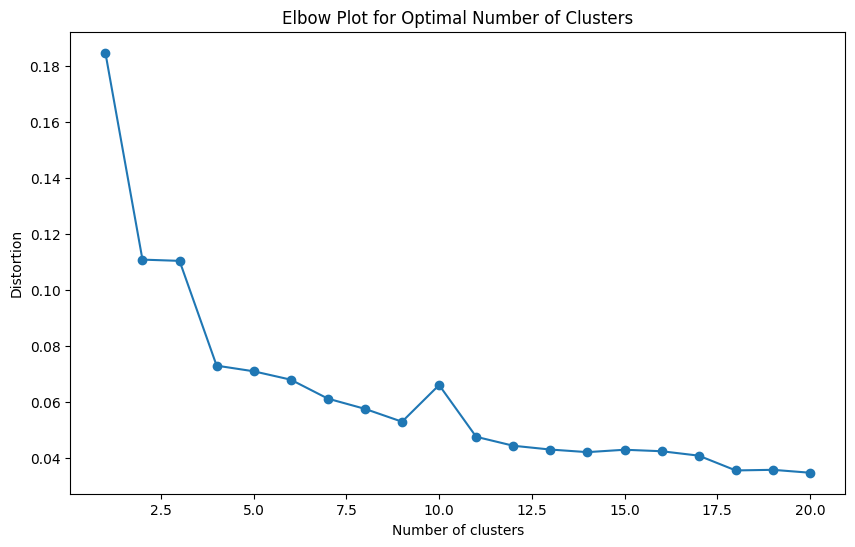

In [5]:
window_size = 15
dataset, indices = segment_time_series(time_series_data, window_size=window_size, shifting_size=window_size)
dataset_scaled = normalize_time_series(dataset)

plot_elbow_method(dataset_scaled, max_clusters=20)

In [6]:
def compute_inertia(X, centers, labels):
# Compute Inertia (within-cluster sum of squares)
    distances, _ = pairwise_distances_argmin_min(X, centers)
    return np.sum(distances**2)

def evaluate_clusters(dataset, k_shape, verbose=False):
  # Evaluation metrics
  # Compute Silhouette Score
  silhouette_avg = silhouette_score(dataset.reshape((dataset.shape[0], -1)), clusters)

  # Compute Davies-Bouldin Index
  db_index = davies_bouldin_score(dataset.reshape((dataset.shape[0], -1)), clusters)

  cluster_centers = k_shape.cluster_centers_.reshape(n_clusters, -1)
  inertia = compute_inertia(dataset.reshape((dataset.shape[0], -1)), cluster_centers, clusters)

  if verbose:
    print(f'Davies-Bouldin Index: {db_index}')
    print(f'Silhouette Score: {silhouette_avg}')
    print(f'Inertia: {inertia}')

  return silhouette_avg, db_index, inertia


In [9]:
results = []
for window_size in [30, 40, 50, 60, 70, 80]:
    n_clusters = 5
    dataset, indices = segment_time_series(time_series_data, window_size=window_size, shifting_size=window_size)
    dataset_scaled = normalize_time_series(dataset)
    clusters, k_shape = perform_k_shape_clustering(dataset_scaled, n_clusters = n_clusters)
    silhouette_avg, db_index, inertia = evaluate_clusters(dataset_scaled, k_shape)
    results.append({
            'window_size': window_size,
            'n_clusters': n_clusters,
            'silhouette_score': silhouette_avg,
            'davies_bouldin_index': db_index,
            'inertia': inertia
    })

results_df = pd.DataFrame(results)

# Display the results
results_df.T


,0,1,2,3,4,5
window_size,30.000000,40.000000,50.000000,60.000000,70.000000,80.000000
n_clusters,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
silhouette_score,0.145350,0.064467,0.081408,0.179084,0.199880,0.030742
davies_bouldin_index,3.133176,2.433239,2.528281,1.705322,1.668406,2.693607
inertia,408.000000,361.000000,460.000000,265.000000,145.000000,239.000000


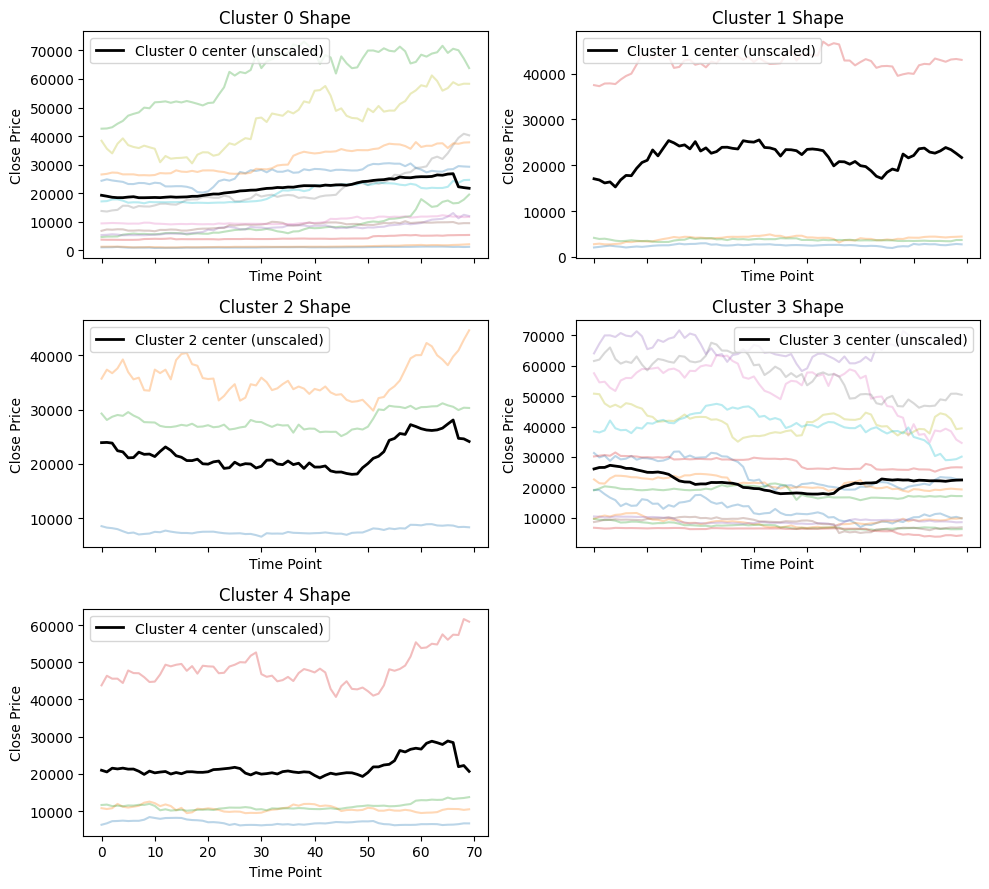

In [10]:
# Hyper parameters
n_clusters = 5
window_size = 70

dataset, indices = segment_time_series(time_series_data, window_size=window_size, shifting_size=window_size)
dataset_scaled = normalize_time_series(dataset)
clusters, k_shape = perform_k_shape_clustering(dataset_scaled, n_clusters = n_clusters)

# Store the original means and standard deviations
original_means = np.nanmean(dataset, axis=1, keepdims=True)
original_stds = np.nanstd(dataset, axis=1, keepdims=True)

# Manually inverse transform the cluster centers to the original scale
cluster_centers_unscaled = k_shape.cluster_centers_ * original_stds.mean(axis=0) + original_means.mean(axis=0)
visualize_k_shape_clusters(cluster_centers_unscaled, clusters, n_clusters, dataset)


In [ ]:
results_df['combined_score'] = (1 - results_df['silhouette_score']) + results_df['davies_bouldin_index'] + results_df['inertia']

# Find the best parameters (the row with the lowest combined score)
best_params = results_df.loc[results_df['combined_score'].idxmin()]

# Set display format for floating point numbers
pd.options.display.float_format = '{:.6f}'.format

# Display the best parameters
print("Best Parameters:")
print(best_params)

# Optionally, display the full DataFrame sorted by the combined score
print("Sorted Results:")
print(results_df.sort_values(by='combined_score'))


Best Parameters:
window_size             60.000000
n_clusters               5.000000
silhouette_score         0.179084
davies_bouldin_index     1.705322
inertia                265.000000
combined_score         267.526238
Name: 5, dtype: float64
Sorted Results:
   window_size  n_clusters  silhouette_score  davies_bouldin_index  inertia  \
5           60           5          0.179084              1.705322      265   
3           40           5          0.064467              2.433239      361   
2           30           5          0.145350              3.133176      408   
4           50           5          0.081408              2.528281      460   
1           20           5          0.090998              4.527237      491   
0           10           5          0.043261              3.448512     1622   

   combined_score  
5      267.526238  
3      364.368772  
2      411.987826  
4      463.446872  
1      496.436239  
0     1626.405252  



##DTW K MEANS CLUSTERING



In [ ]:
def perform_dtw_clustering(dataset, n_clusters):
    # Using KMeans with DTW as the metric
    model = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", random_state=42)
    clusters = model.fit_predict(dataset)
    return clusters, model

def compute_inertia_dtw(X, model):
    # Compute inertia for DTW clustering
    distances = np.zeros(X.shape[0])
    for i, x in enumerate(X):
        distances[i] = dtw(x, model.cluster_centers_[model.labels_[i]])
    return np.sum(distances**2)

def evaluate_clusters_dtw(dataset, clusters, model, verbose=False):
    # Evaluation metrics
    silhouette_avg = silhouette_score(dataset.reshape((dataset.shape[0], -1)), clusters)
    db_index = davies_bouldin_score(dataset.reshape((dataset.shape[0], -1)), clusters)
    inertia = compute_inertia_dtw(dataset, model)
    if verbose:
      print(f'Davies-Bouldin Index: {db_index}')
      print(f'Silhouette Score: {silhouette_avg}')
      print(f'Inertia: {inertia}')


    return silhouette_avg, db_index, inertia

def plot_elbow_method(dataset, max_clusters=20):
    distortions = []
    for i in range(1, max_clusters+1):
        _, model = perform_dtw_clustering(dataset, n_clusters=i)
        distortions.append(model.inertia_)  # Within-cluster sum of squares

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_clusters+1), distortions, marker='o')
    plt.title('Elbow Plot for Optimal Number of Clusters')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.show()



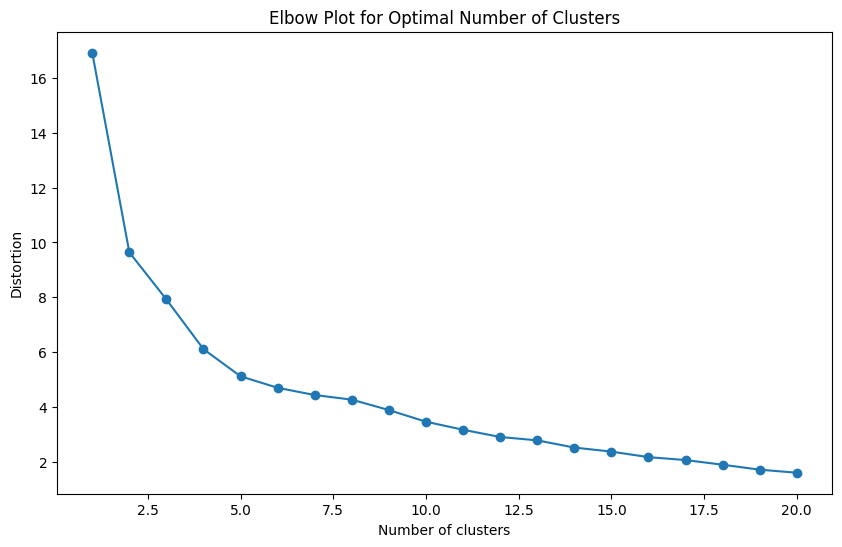

In [ ]:
plot_elbow_method(dataset_scaled)

In [ ]:
n_clusters = 6
window_size = 10
dataset, indices = segment_time_series(time_series_data, window_size=window_size, shifting_size=window_size)
dataset_scaled = normalize_time_series(dataset)
clusters, model = perform_dtw_clustering(dataset_scaled, n_clusters=n_clusters)
evaluate_clusters_dtw(dataset_scaled, clusters, model)

(0.11680966539398654, 2.206857771284755, 661.7245344103817)

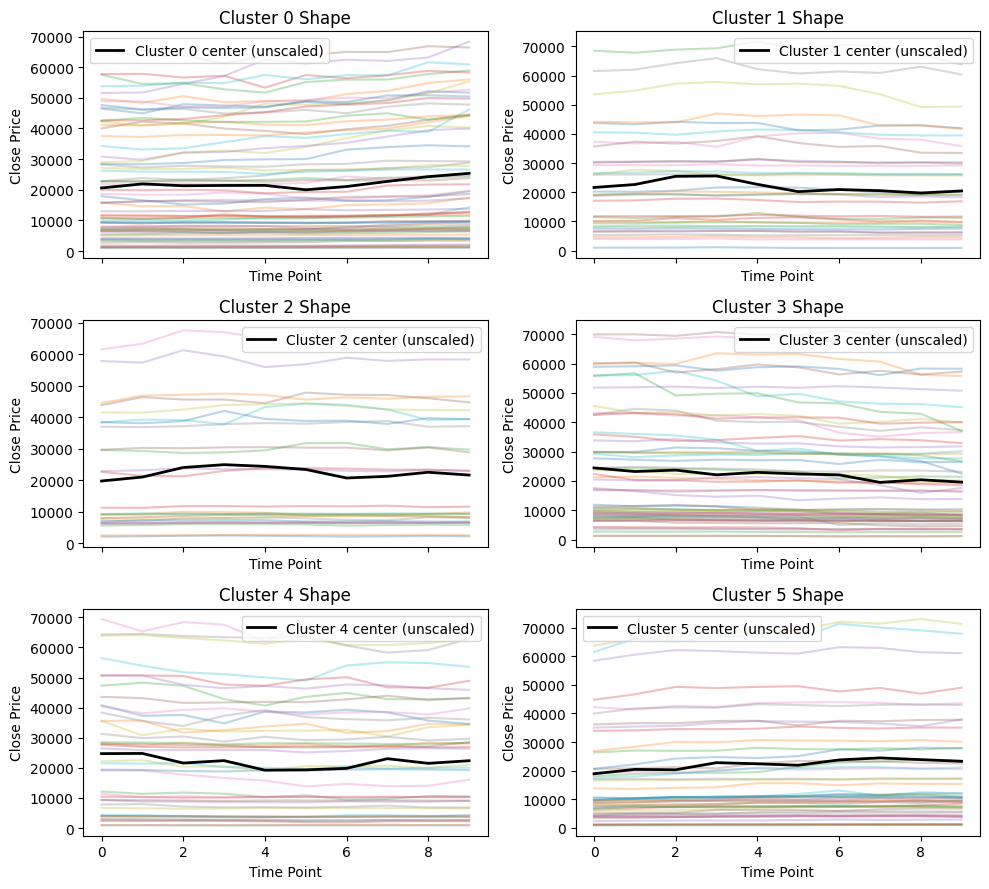

In [ ]:
cluster_centers_unscaled = model.cluster_centers_ * original_stds.mean(axis=0) + original_means.mean(axis=0)
visualize_k_shape_clusters(cluster_centers_unscaled, clusters, n_clusters, dataset)


In [ ]:
best_window_size = 40
cluster_labels = np.full(len(time_series_data), -1)

# Map the clusters back to the original time series data
for i, cluster in enumerate(clusters):
    start_idx = indices[i]
    end_idx = start_idx + best_window_size
    cluster_labels[start_idx:end_idx] = cluster


In [ ]:
original_df = pd.read_csv('./BTC-USD.csv')

In [ ]:
time_series_df = pd.DataFrame(time_series_data)
time_series_df['cluster'] = cluster_labels

In [ ]:
time_series_df

In [ ]:
from statsmodels.tsa.seasonal import STL


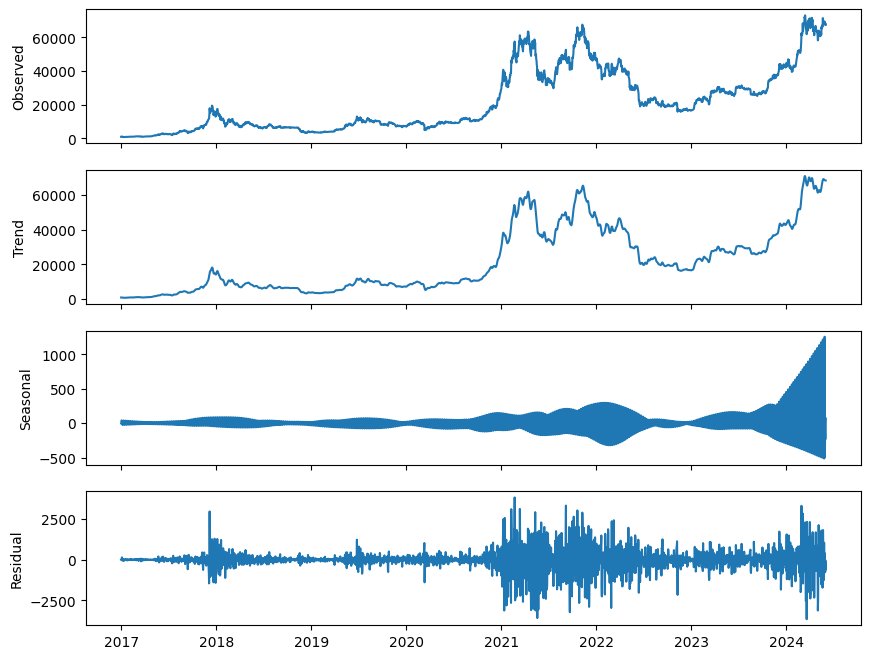

In [ ]:
# Perform time series decomposition on the 'Close' column
result = STL(data['Close'], seasonal=63).fit()

# Plot the decomposition results
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8), sharex=True)

ax1.plot(result.observed)
ax1.set_ylabel('Observed')

ax2.plot(result.trend)
ax2.set_ylabel('Trend')

ax3.plot(result.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(result.resid)
ax4.set_ylabel('Residual')

plt.show()


=======================following is from Xinmei Luan================

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
from statsmodels.stats.outliers_influence import variance_inflation_factor
from collections import Counter

the 3rd dataset of df2.

In [ ]:
df_super=df2
df_super['Date']=pd.to_datetime(df_super['Date'])
df_super['year']=df_super['Date'].dt.year
df_super['month']=df_super['Date'].dt.month
df_super['day']=df_super['Date'].dt.day

In [ ]:
#UMAP to find outliers,since there is right enviroment to run below codes in unsupervised learning A1.when i import umap, it does not work. therefore, Below is marked out
#import umap

#def answer_outlier_a():
#    umap_obj = umap.UMAP(set_op_mix_ratio=0.15, random_state = 0)
#    result=umap_obj.fit(X_scaled)

#    return result
#def answer_outlier_b():
#    clf = LocalOutlierFactor(n_neighbors=10).fit(answer_outlier_a().embedding_)
#    result_d = clf.negative_outlier_factor_
#    result=np.argsort(result_d)[:100]


#    return result
#outliers_list=answer_outlier_b()

In [ ]:
#will use this directly from A1 to remove outliers
outliers_list=[1517, 1515, 1516, 1518, 1519, 1520, 1521, 1522, 1178, 1488, 1487,
       1489, 1490, 1491, 1493, 1492, 2427, 2428, 1180, 1175]

see correclation matrix first to check relationship among features.

In [ ]:
scaler=StandardScaler()
scaled_data = scaler.fit_transform(df_super.drop(['Date'],axis=1))
correlation_matrix = pd.DataFrame(scaled_data,columns=df_super.columns.drop(['Date'])).corr()

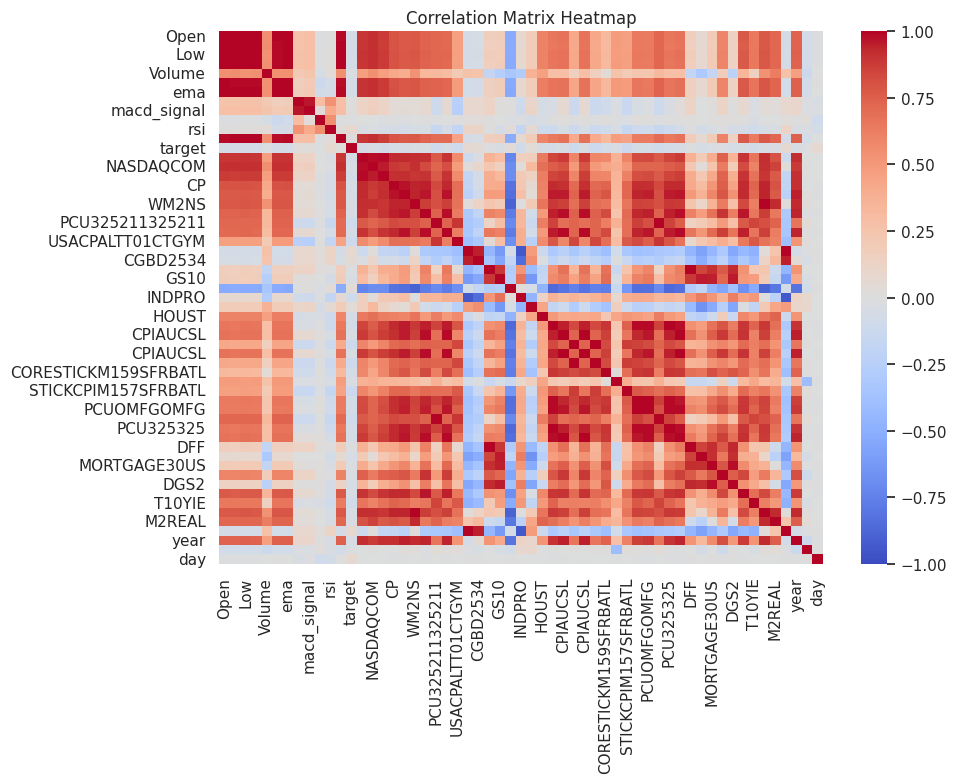

In [ ]:
plt.figure(figsize=(10, 8))
sns.set(font_scale = 1)
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix Heatmap')
plt.tight_layout()
plt.show()

In [ ]:
#show pairs correlation higher than 0.95
threshold = 0.95
strong_corr_pairs = (correlation_matrix.abs() > threshold) & (correlation_matrix.abs() < 1.0)
strong_corr_indices = strong_corr_pairs.where(strong_corr_pairs).stack().index.tolist()
print("Strongly correlated feature pairs:", strong_corr_indices)

Strongly correlated feature pairs: [('Open', 'High'), ('Open', 'Low'), ('Open', 'Close'), ('Open', 'sma'), ('Open', 'ema'), ('Open', 'nextClose'), ('High', 'Open'), ('High', 'Low'), ('High', 'Close'), ('High', 'sma'), ('High', 'ema'), ('High', 'nextClose'), ('Low', 'Open'), ('Low', 'High'), ('Low', 'Close'), ('Low', 'sma'), ('Low', 'ema'), ('Low', 'nextClose'), ('Close', 'Open'), ('Close', 'High'), ('Close', 'Low'), ('Close', 'sma'), ('Close', 'ema'), ('Close', 'nextClose'), ('sma', 'Open'), ('sma', 'High'), ('sma', 'Low'), ('sma', 'Close'), ('sma', 'ema'), ('sma', 'nextClose'), ('ema', 'Open'), ('ema', 'High'), ('ema', 'Low'), ('ema', 'Close'), ('ema', 'sma'), ('ema', 'nextClose'), ('macd', 'macd_signal'), ('macd_signal', 'macd'), ('nextClose', 'Open'), ('nextClose', 'High'), ('nextClose', 'Low'), ('nextClose', 'Close'), ('nextClose', 'sma'), ('nextClose', 'ema'), ('SP500', 'NASDAQCOM'), ('SP500', 'DJIA'), ('NASDAQCOM', 'SP500'), ('NASDAQCOM', 'DJIA'), ('DJIA', 'SP500'), ('DJIA', 'NAS

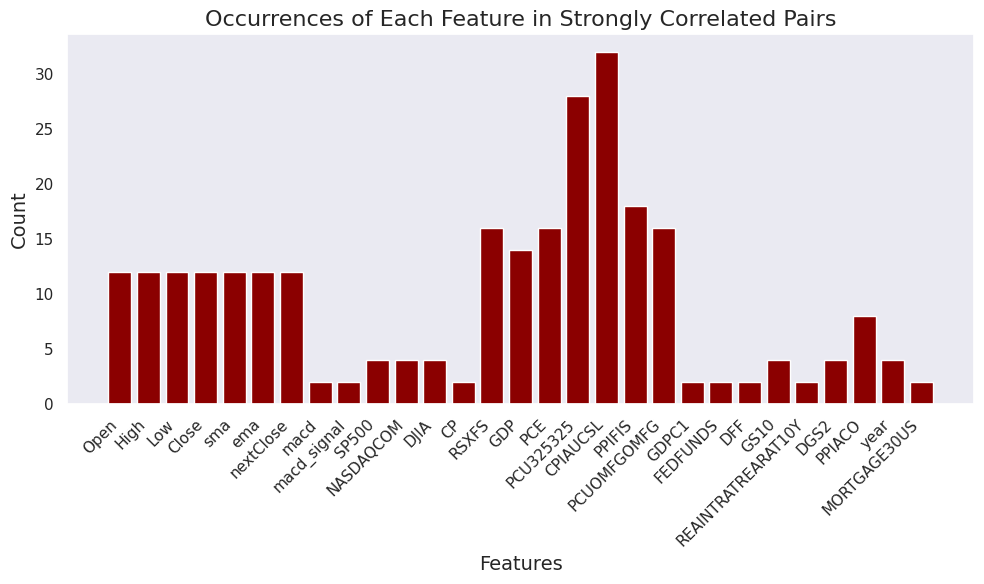

In [ ]:

flattened_features = [feature for pair in strong_corr_indices for feature in pair]
feature_counts = Counter(flattened_features)

# Display the counts


# Extract features and their counts
features = list(feature_counts.keys())
counts = list(feature_counts.values())

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(features, counts, color='darkred')

# Add title and labels
plt.title('Occurrences of Each Feature in Strongly Correlated Pairs', fontsize=16)
plt.xlabel('Features', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.grid(False)

# Rotate x labels for better readability
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.show()

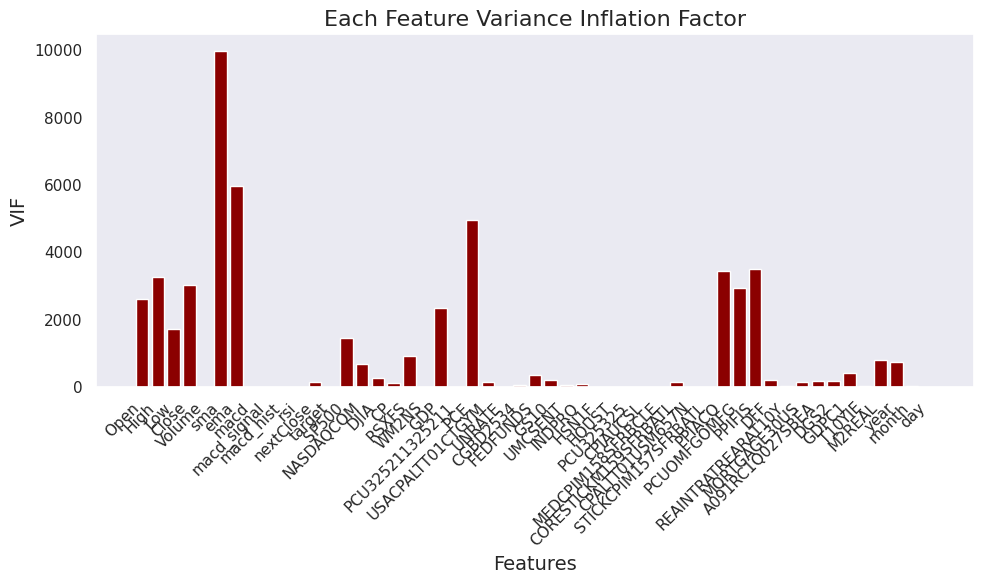

In [ ]:
#Calculate the Variance Inflation Factor VIF for each feature to quantify how much the variance of an estimated regression
#coefficient increases due to multicollinearity

vif_data = pd.DataFrame()
vif_data["feature"] = df_super.drop(['Date'],axis=1).columns
vif_data["VIF"] = [variance_inflation_factor(scaled_data, i) for i in range(scaled_data.shape[1])]
vif_data.sort_values(['VIF'],ascending= False)
plt.figure(figsize=(10, 6))
plt.bar(vif_data.feature, vif_data.VIF, color='darkred')
plt.grid(None)
# Add title and labels
plt.title('Each Feature Variance Inflation Factor', fontsize=16)
plt.xlabel('Features', fontsize=14)
plt.ylabel('VIF', fontsize=14)


# Rotate x labels for better readability
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.show()

find out important features, this is featrue selection 1

In [ ]:
X=df_super.drop(['target','Date','nextClose'],axis=1)
y=df_super['target']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=42)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
models = {
    'RandomForest': RandomForestClassifier(random_state=42,class_weight='balanced'),
    'DecisionTree': DecisionTreeClassifier(random_state=42,class_weight='balanced'),
    #'SVM': SVC(),
    'LogisticRegression': LogisticRegression(random_state=42, penalty='l2', solver='lbfgs'),
    'KNN': KNeighborsClassifier(n_jobs = -1)}

In [ ]:
param_grids = {
        'RandomForest': {
            'n_estimators': [50,100],
            "min_samples_split": [2, 5, 10],
            'max_depth': [10, 20],
        },
        'DecisionTree': {
            "min_samples_split": [2, 10, 20],
            'max_depth': [None, 10, 20],
        },
        'LogisticRegression': {
            'C': [0.1, 1, 10],
            "solver": ['lbfgs'],
            "max_iter": [100, 200],
        },
        'KNN': {
          'n_neighbors': [3, 5, 7]
        }
    }

In [ ]:
def find_best_params(X_train_scaled, y_train):  #from Irene
    param_grids = {
        'RandomForest': {
            'n_estimators': [50,100,150],
            "min_samples_split": [2, 5, 10, 20],
            'max_depth': [None,10, 20],
        },
        'DecisionTree': {
            "min_samples_split": [2, 5, 10, 20],
            'max_depth': [None, 10, 20],
        },
        'LogisticRegression': {
            'C': [0.01, 0.1, 1, 10],
            "multi_class": ['multinomial', "ovr"],
            "max_iter": [100, 200, 300],
        },
        'KNN': {
          'n_neighbors': [3, 5, 7]

        }
    }
    results = []
    for model_name, model in models.items():
        print(f"Training {model_name}...")
        tscv = TimeSeriesSplit(n_splits=5)
        grid_search = GridSearchCV(estimator=model, param_grid=param_grids[model_name], cv=tscv, n_jobs=-1)
        grid_search.fit(X_train_scaled, y_train)
        best_params = grid_search.best_params_
        best_model = grid_search.best_estimator_
        score = grid_search.best_score_
        if hasattr(best_model, 'feature_importances_'):
            feature_importance = best_model.feature_importances_[0:20]
        elif hasattr(best_model, 'coef_'):
            feature_importance = best_model.coef_[0][0:20]
        else:
            feature_importance = None
        results.append({
            'Model': model_name,
            'Best Parameters': best_params,
            'Feature Importance': feature_importance,
            'score': score
        })
    return pd.DataFrame(results)

In [ ]:
def all_model_fit(X_train_scaled, y_train, X_test_scaled, y_test, df_best_params):  #from Irene
    results = []
    for i in range(len(df_best_params)):
        model_name = df_best_params.iloc[i]['Model']
        best_params = df_best_params.iloc[i]['Best Parameters']
        model = models[model_name].set_params(**best_params)
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        conf_matrix = confusion_matrix(y_test, y_pred)
        accuracy = accuracy_score(y_test, y_pred)
        feature_importance = None
        if hasattr(model, 'feature_importances_'):
            feature_importance = model.feature_importances_[0:20]
        elif hasattr(model, 'coef_'):
            feature_importance = model.coef_[0][0:20]
        results.append({
            'Model': model_name,
            'Best Parameters': best_params,
            'Confusion Matrix': conf_matrix,
            'Accuracy': accuracy,
            'Feature Importance': feature_importance,

        })
    return pd.DataFrame(results)

In [ ]:
df_best_params = find_best_params(X_train_scaled, y_train)
df_all_model_fit = all_model_fit(X_train_scaled, y_train, X_test_scaled, y_test, df_best_params)
df_all_model_fit

Training RandomForest...
Training DecisionTree...
Training LogisticRegression...
Training KNN...


,Model,Best Parameters,Confusion Matrix,Accuracy,Feature Importance
0,RandomForest,"{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}","[[111, 22, 9], [25, 133, 41], [6, 33, 157]]",0.746741,"[0.04026989268269768, 0.04377602414622049, 0.0472828550995279, 0.05186585391963096, 0.04172351517113149, 0.04663570791511283, 0.04383127335324232, 0.04591510351872194, 0.05012023977346946, 0.04909731743906036, 0.04641975986485292, 0.03751476522310695, 0.03912779905030632, 0.03971763803746855, 0.001584751962337123, 0.004234316555661304, 0.02681230699506398, 0.0015658218262191376, 0.003922029504919491, 0.004927279286362271]"
1,DecisionTree,"{'max_depth': 20, 'min_samples_split': 2}","[[103, 28, 11], [34, 119, 46], [15, 42, 139]]",0.672253,"[0.023051771814752764, 0.03293030642225799, 0.042073988063257205, 0.06565935648033623, 0.050603317832250264, 0.038369400022131836, 0.046721437887450805, 0.06547086890417071, 0.07429913184750916, 0.08546329718052595, 0.06270629655533444, 0.02273409499775911, 0.03457692221693373, 0.021531346335737164, 0.0, 0.0, 0.018817855316920096, 2.066976278739723e-18, 0.0026373625919563766, 0.0]"
2,LogisticRegression,"{'C': 10, 'max_iter': 100, 'multi_class': 'multinomial'}","[[50, 33, 59], [36, 102, 61], [33, 50, 113]]",0.493482,"[-0.2413656704906728, -0.38633785245380386, 0.050819461630651416, 0.6001717702177644, 0.14590196337957395, 0.414580063683296, 0.5148422362280438, -0.03312256671382349, -0.07282388978490885, 0.1340250640704972, -0.019088816213630372, 0.4899055827824217, -0.09089795690634987, 0.026103245256213797, 1.0804930575135276, 0.20572099025496593, 0.10844294492868417, -0.23393742695730343, -0.289779421673129, -0.1102706046368873]"
3,KNN,{'n_neighbors': 3},"[[113, 21, 8], [48, 111, 40], [22, 30, 144]]",0.685289,None


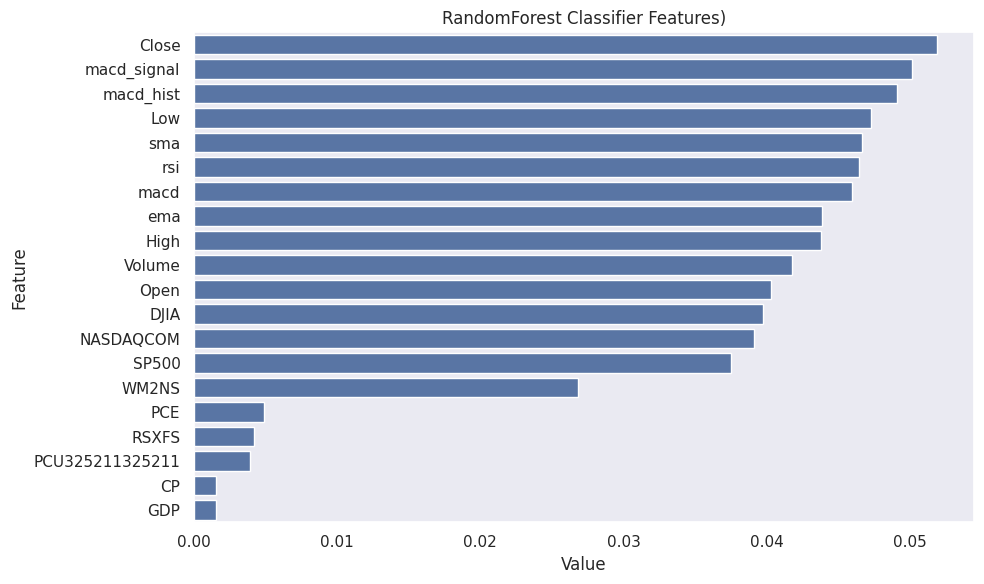

In [ ]:
feature_imp= pd.DataFrame({'Value':df_all_model_fit.iloc[0,4],'Feature':X.columns[0:20]})
plt.figure(figsize=(10, 6))
sns.set(font_scale = 1)
plt.grid(None)
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:20])
plt.title('RandomForest Classifier Features)')
plt.tight_layout()
plt.show()

In [ ]:
mlp = MLPClassifier(
    hidden_layer_sizes=[50, 50], alpha=1, random_state=42, solver="lbfgs"
).fit(X_train_scaled, y_train)
y_predicted=mlp.predict(X_test_scaled)
conf_matrix = confusion_matrix(y_test, y_predicted)
print(conf_matrix,accuracy_score(y_test, y_predicted))

[[ 99  29  14]
 [ 30 128  41]
 [ 11  38 147]] 0.6964618249534451


In [ ]:
from sklearn.inspection import permutation_importance
r = permutation_importance(mlp, X_test_scaled, y_test,
                           n_repeats=30,
                           random_state=42)

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{X.columns.values[i]:<8}"
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

Close   0.241 +/- 0.019
INDPRO  0.202 +/- 0.016
DGS2    0.144 +/- 0.017
CPALTT01USM657N0.142 +/- 0.015
CORESTICKM159SFRBATL0.142 +/- 0.015
day     0.141 +/- 0.014
Low     0.133 +/- 0.016
rsi     0.133 +/- 0.016
CP      0.130 +/- 0.016
MORTGAGE30US0.128 +/- 0.016
month   0.128 +/- 0.015
year    0.126 +/- 0.011
UMCSENT 0.119 +/- 0.014
STICKCPIM157SFRBATL0.118 +/- 0.014
MEDCPIM158SFRBCLE0.118 +/- 0.012
DFF     0.118 +/- 0.012
USACPALTT01CTGYM0.113 +/- 0.012
T10YIE  0.112 +/- 0.011
HSN1F   0.106 +/- 0.013
PCU3252113252110.105 +/- 0.012
GDPC1   0.103 +/- 0.013
MEDCPIM158SFRBCLE0.100 +/- 0.013
REAINTRATREARAT10Y0.092 +/- 0.014
DJIA    0.091 +/- 0.012
macd_hist0.090 +/- 0.012
sma     0.088 +/- 0.012
CPIAUCSL0.088 +/- 0.011
HOUST   0.084 +/- 0.011
Volume  0.082 +/- 0.013
GDP     0.081 +/- 0.011
PPIACO  0.079 +/- 0.013
High    0.078 +/- 0.015
CPIAUCSL0.075 +/- 0.011
PCE     0.073 +/- 0.011
ema     0.072 +/- 0.013
M2REAL  0.072 +/- 0.012
NASDAQCOM0.070 +/- 0.010
Open    0.066 +/- 0.011
SP500   0

let us do ablation test

In [ ]:
#by combining above feature importances and also select feautres are not multicollinearity, we chosed 13 features in total,after ablation test, we realized that we need to remove MACD-hist.
# I changed it in my workbook
short_list=['Close','CPALTT01USM657N','day','month','macd_signal','macd_hist','macd','Low','rsi','High','Volume','Open','PPIFIS']
df_shorter_2=df_super[short_list]

In [ ]:
X=df_shorter_2
y=df_super['target']
scaler=StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
X_train_scaled= scaler.fit_transform(X_train)
X_test_scaled= scaler.transform(X_test)
X_train=pd.DataFrame(X_train_scaled, columns=X.columns)
X_test=pd.DataFrame(X_test_scaled, columns=X.columns)

In [ ]:
#let us use the best model above mentioned
rf_model=RandomForestClassifier(random_state=42,class_weight='balanced',max_depth=None,
                           min_samples_split=2, n_estimators=100).fit(X_train_scaled, y_train)

Feature Importances:
             Feature  Importance
4       macd_signal    0.099699
5         macd_hist    0.093447
6              macd    0.090991
2               day    0.087626
0             Close    0.086551
8               rsi    0.084798
10           Volume    0.084581
9              High    0.082118
7               Low    0.081038
11             Open    0.072204
12           PPIFIS    0.054798
1   CPALTT01USM657N    0.042589
3             month    0.039560


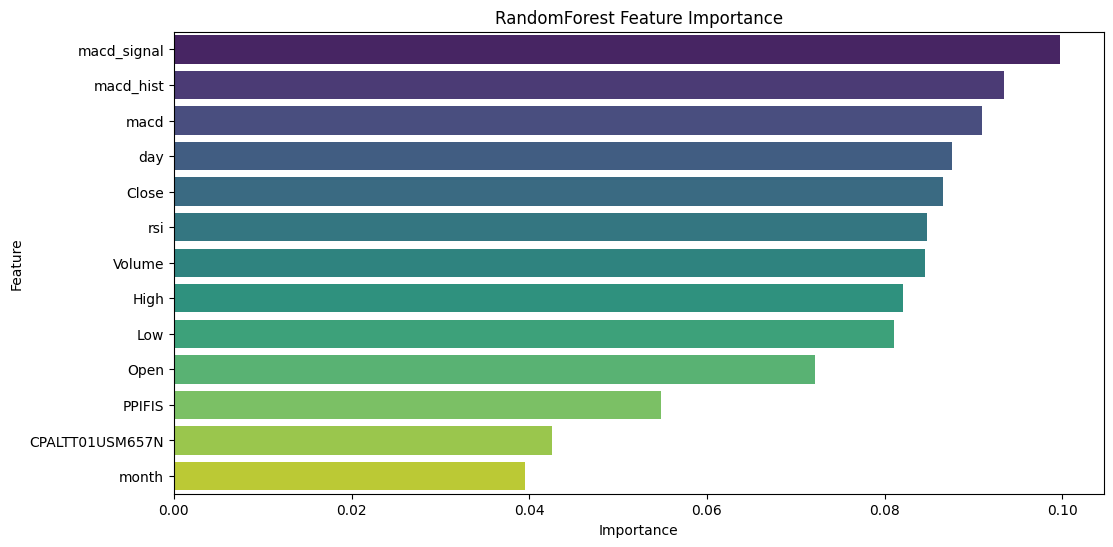

Full Model - Accuracy: 0.7318, F1 Score: 0.7323
Ablation Test Results:
             Feature  Accuracy Drop  F1 Score Drop
12           PPIFIS       0.011173       0.011784
3             month       0.009311       0.008902
4       macd_signal       0.003724       0.003912
9              High       0.003724       0.003785
8               rsi       0.001862       0.002462
0             Close      -0.001862      -0.001537
7               Low      -0.001862      -0.001656
1   CPALTT01USM657N      -0.003724      -0.003289
5         macd_hist      -0.003724      -0.003541
10           Volume      -0.005587      -0.005162
11             Open      -0.005587      -0.005969
6              macd      -0.009311      -0.009193
2               day      -0.009311      -0.009708


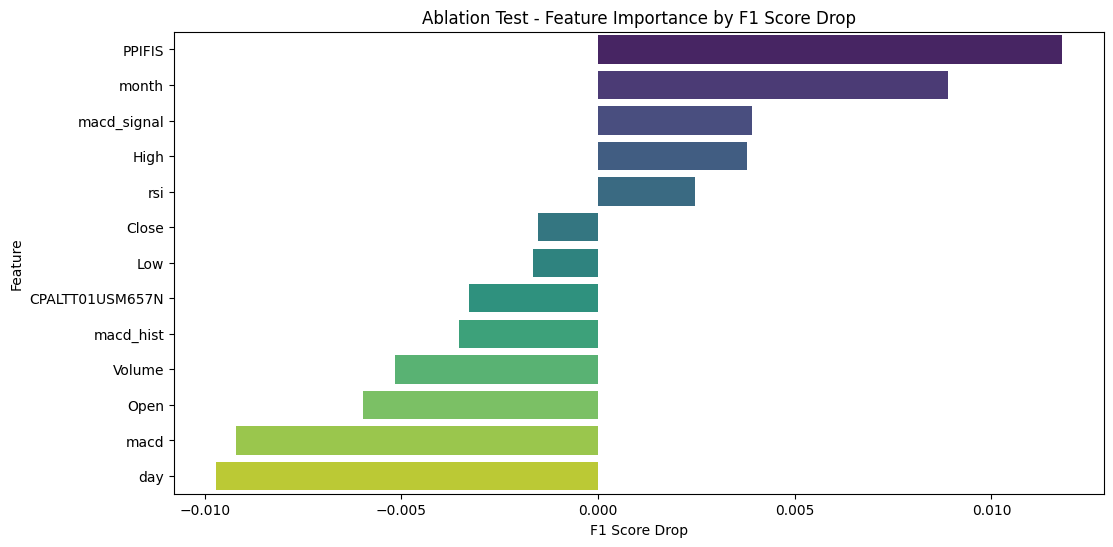

In [ ]:
# Get feature importances
feature_importances = rf_model.feature_importances_
features = X_train.columns

# Create a DataFrame for easy viewing
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print("Feature Importances:\n", importance_df)

# Plot the feature importances
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('RandomForest Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Perform ablation testing
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    return accuracy, f1

# Evaluate the full model
full_accuracy, full_f1 = evaluate_model(rf_model, X_train, y_train, X_test, y_test)
print(f"Full Model - Accuracy: {full_accuracy:.4f}, F1 Score: {full_f1:.4f}")

# Perform ablation testing
feature_importance = []
for feature in X_train.columns:
    # Drop one feature
    X_train_ablate = X_train.drop(columns=[feature])
    X_test_ablate = X_test.drop(columns=[feature])
    # Evaluate the model without this feature
    accuracy, f1 = evaluate_model(rf_model, X_train_ablate, y_train, X_test_ablate, y_test)
    # Calculate the difference in performance
    accuracy_diff = full_accuracy - accuracy
    f1_diff = full_f1 - f1
    # Store the results
    feature_importance.append((feature, accuracy_diff, f1_diff))

# Convert results to a DataFrame for easy viewing
ablation_results = pd.DataFrame(feature_importance, columns=['Feature', 'Accuracy Drop', 'F1 Score Drop'])
print("Ablation Test Results:\n", ablation_results.sort_values(by='F1 Score Drop', ascending=False))

# Plot ablation results
ablation_results_sorted = ablation_results.sort_values(by='F1 Score Drop', ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x='F1 Score Drop', y='Feature', data=ablation_results_sorted, palette='viridis')
plt.title('Ablation Test - Feature Importance by F1 Score Drop')
plt.xlabel('F1 Score Drop')
plt.ylabel('Feature')
plt.show()

after remove MACD-hist

In [ ]:
short_list=['Close','CPALTT01USM657N','day','month','macd_signal','macd','Low','rsi','High','Volume','Open','PPIFIS']
df_shorter_3=df_super[short_list]

In [ ]:
X=df_shorter_3
y=df_super['target']
scaler=StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
X_train_scaled= scaler.fit_transform(X_train)
X_test_scaled= scaler.transform(X_test)
X_train=pd.DataFrame(X_train_scaled, columns=X.columns)
X_test=pd.DataFrame(X_test_scaled, columns=X.columns)

Feature Importances:
             Feature  Importance
4       macd_signal    0.102532
5              macd    0.098925
10             Open    0.094203
6               Low    0.094020
8              High    0.091105
2               day    0.089129
0             Close    0.086041
9            Volume    0.083054
7               rsi    0.081777
11           PPIFIS    0.080709
1   CPALTT01USM657N    0.051742
3             month    0.046761


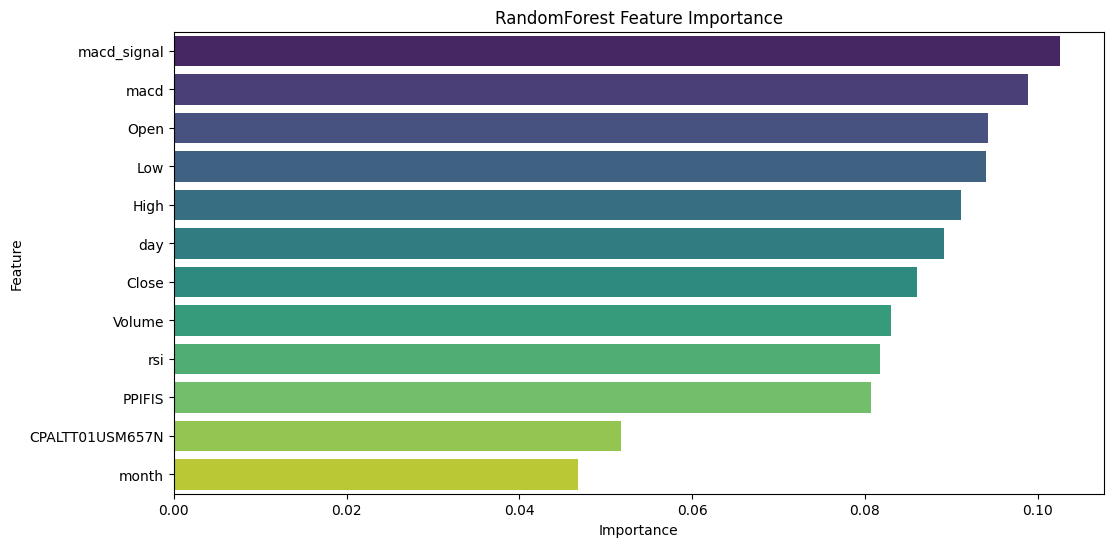

Full Model - Accuracy: 0.7356, F1 Score: 0.7359
Ablation Test Results:
             Feature  Accuracy Drop  F1 Score Drop
0             Close       0.029795       0.030404
7               rsi       0.029795       0.030154
11           PPIFIS       0.022346       0.022611
5              macd       0.013035       0.013446
1   CPALTT01USM657N       0.011173       0.011514
9            Volume       0.011173       0.011262
6               Low       0.009311       0.009778
2               day       0.007449       0.007626
10             Open       0.003724       0.004416
4       macd_signal       0.003724       0.004100
8              High       0.003724       0.003921
3             month       0.001862       0.002219


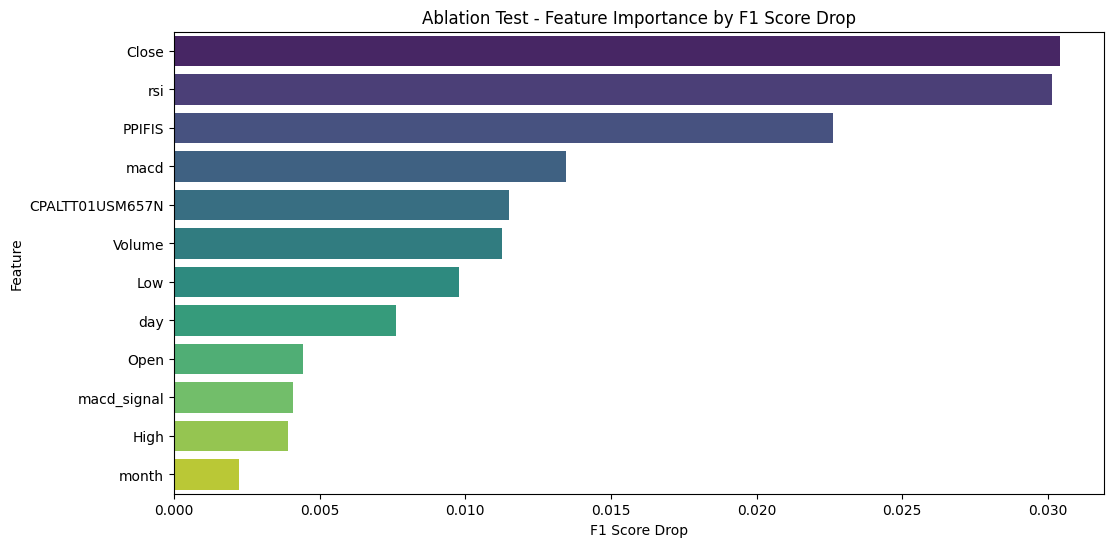

In [ ]:
# Get feature importances
feature_importances = rf_model.feature_importances_
features = X_train.columns

# Create a DataFrame for easy viewing
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print("Feature Importances:\n", importance_df)

# Plot the feature importances
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('RandomForest Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Perform ablation testing
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    return accuracy, f1

# Evaluate the full model
full_accuracy, full_f1 = evaluate_model(rf_model, X_train, y_train, X_test, y_test)
print(f"Full Model - Accuracy: {full_accuracy:.4f}, F1 Score: {full_f1:.4f}")

# Perform ablation testing
feature_importance = []
for feature in X_train.columns:
    # Drop one feature
    X_train_ablate = X_train.drop(columns=[feature])
    X_test_ablate = X_test.drop(columns=[feature])
    # Evaluate the model without this feature
    accuracy, f1 = evaluate_model(rf_model, X_train_ablate, y_train, X_test_ablate, y_test)
    # Calculate the difference in performance
    accuracy_diff = full_accuracy - accuracy
    f1_diff = full_f1 - f1
    # Store the results
    feature_importance.append((feature, accuracy_diff, f1_diff))

# Convert results to a DataFrame for easy viewing
ablation_results = pd.DataFrame(feature_importance, columns=['Feature', 'Accuracy Drop', 'F1 Score Drop'])
print("Ablation Test Results:\n", ablation_results.sort_values(by='F1 Score Drop', ascending=False))

# Plot ablation results
ablation_results_sorted = ablation_results.sort_values(by='F1 Score Drop', ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x='F1 Score Drop', y='Feature', data=ablation_results_sorted, palette='viridis')
plt.title('Ablation Test - Feature Importance by F1 Score Drop')
plt.xlabel('F1 Score Drop')
plt.ylabel('Feature')
plt.show()

model evaluation

In [ ]:
initial_train_size = int(len(df_super))-500
test_size = 100
n_splits=5

In [ ]:
def walk_forward_validation(X, y, initial_train_size, test_size, model, param_grid):

  n_splits = 500
  tscv = TimeSeriesSplit(n_splits=n_splits)

  best_params = None
  best_score = 0
  y_true, y_pred = [], []
  accuracies = []
  classification_reports = []

  for i in range(n_splits):
    train_end = initial_train_size + i * test_size
    test_end = train_end + test_size
    if test_end > len(X):
      break

    X_train, X_test = X.iloc[:train_end], X.iloc[train_end:test_end]
    y_train, y_test = y.iloc[:train_end], y.iloc[train_end:test_end]

    if len(X_test) == 0:
      continue

    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy')
    grid_search.fit(X_train_scaled, y_train)

    if grid_search.best_score_ > best_score:
      best_score = grid_search.best_score_
      best_params = grid_search.best_params_

      best_model = grid_search.best_estimator_
      y_pred.extend(best_model.predict(X_test_scaled))
      y_true.extend(y_test)

  accuracy = accuracy_score(y_true, y_pred)
  accuracies.append(accuracy)

  report = classification_report(y_true, y_pred, output_dict=True)
  classification_reports.append(report)
  return accuracies, classification_reports,best_params

In [ ]:
def df_results_and_visualization(models, param_grids, X, y, initial_train_size, test_size):
  results = []
  best_params_dict = {}
  for model_name, model in models.items():
    param_grid = param_grids[model_name]
    accuracies, reports,best_params = walk_forward_validation(X, y, initial_train_size, test_size, model, param_grid)
    best_params_dict[model_name] = best_params

    for accuracy, report in zip(accuracies, reports):
      results.append({
            'model': model_name,
            'accuracy': accuracy,
            'precision_-1': report['-1']['precision'],
            'recall_-1': report['-1']['recall'],
            'f1_score_-1': report['-1']['f1-score'],
            'precision_0': report['0']['precision'],
            'recall_0': report['0']['recall'],
            'f1_score_0': report['0']['f1-score'],
            'precision_1': report['1']['precision'],
            'recall_1': report['1']['recall'],
            'f1_score_1': report['1']['f1-score']
             })
  df_results = pd.DataFrame(results)
    #show accuracy
  plt.figure(figsize=(6, 4))
  sns.boxplot(x='model', y='accuracy', data=df_results)
  plt.title('Walk-Forward Validation Accuracy Distribution for Different Models')
  plt.ylabel('Accuracy')
  plt.ylim(0, 1)
  plt.grid(None)
  plt.xticks(rotation=45)
  plt.show()


  fig, axes = plt.subplots(3, 3, figsize=(12, 10))

    # List of metrics and classes
  metrics = ['precision', 'recall', 'f1_score']
  classes = ['-1', '0', '1']

    # Plot each metric for each class
  for i, metric in enumerate(metrics):
    for j, cls in enumerate(classes):
      sns.boxplot(x='model', y=f'{metric}_{cls}', data=df_results, ax=axes[i, j])
      axes[i, j].set_title(f'{metric.capitalize()} for Class {cls}')
      axes[i, j].set_ylim(0, 1)
      axes[i, j].set_ylabel(metric.capitalize())
      axes[i, j].set_xticklabels(axes[i, j].get_xticklabels(), rotation=45)


  plt.tight_layout()
  plt.show()

  for model_name, params in best_params_dict.items():
    print(f"Best parameters for {model_name}: {params}")

  return df_results

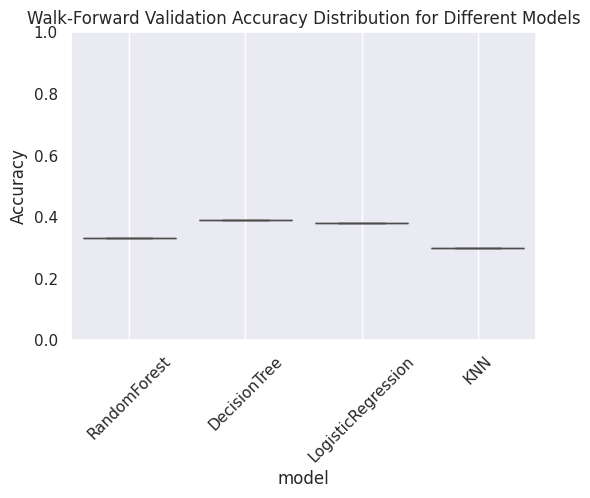

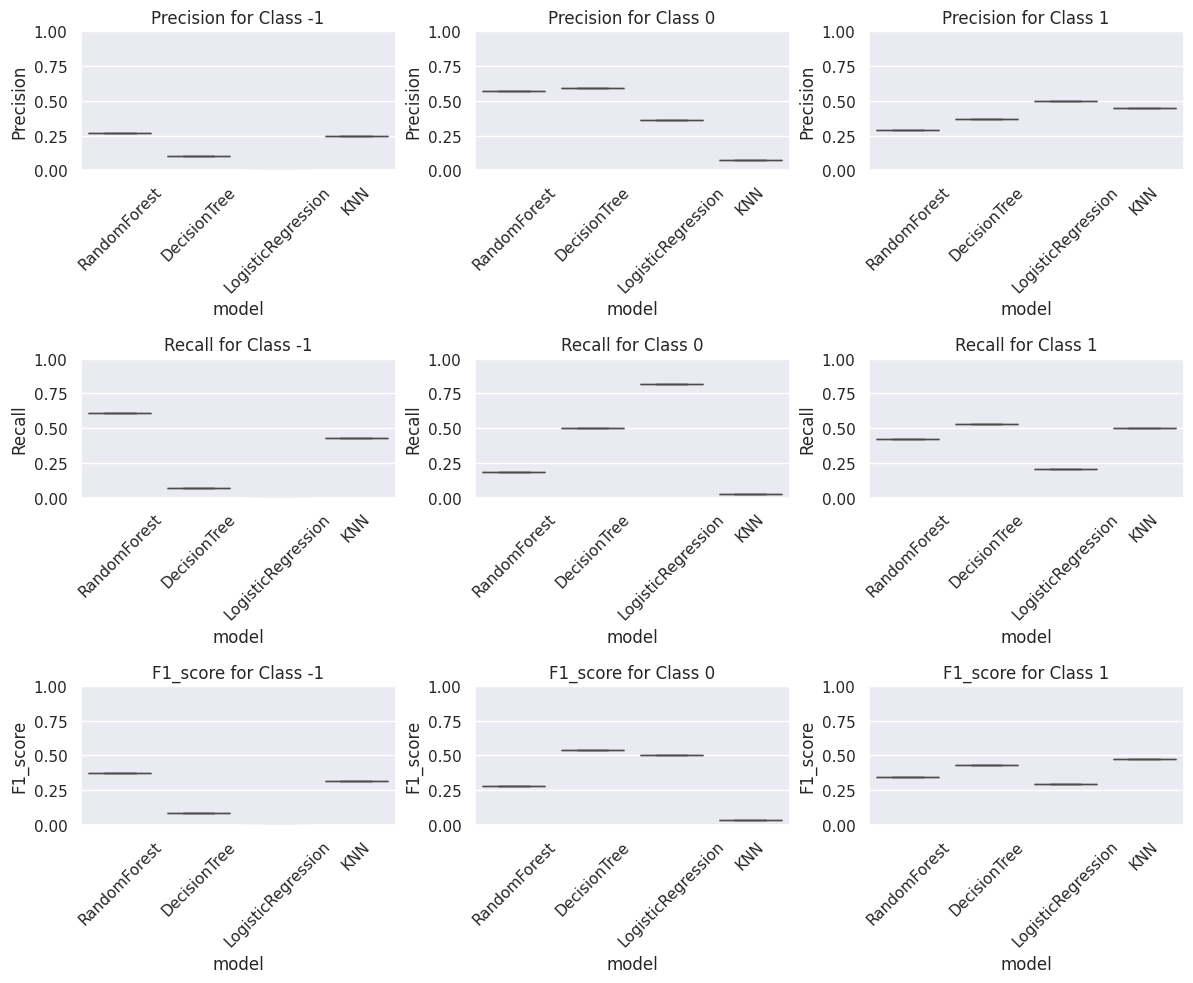

Best parameters for RandomForest: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}
Best parameters for DecisionTree: {'max_depth': None, 'min_samples_split': 10}
Best parameters for LogisticRegression: {'C': 0.1, 'max_iter': 100, 'solver': 'lbfgs'}
Best parameters for KNN: {'n_neighbors': 3}


In [ ]:
#start evaluation from df_super, the complete dataset. it seems that the calcualtion is too much here, let us test the shorter file.
short_list=['Close','CPALTT01USM657N','day','month','macd_signal','macd_hist','macd','Low','rsi','High','Volume','Open','PPIFIS']
df_shorter_2=df_super[short_list]

df_results = df_results_and_visualization(models, param_grids, df_shorter_2, y, initial_train_size, test_size)

In [ ]:
df_results

,model,accuracy,precision_-1,recall_-1,f1_score_-1,precision_0,recall_0,f1_score_0,precision_1,recall_1,f1_score_1
0,RandomForest,0.33,0.268817,0.609756,0.373134,0.571429,0.183486,0.277778,0.291667,0.420000,0.344262
1,DecisionTree,0.39,0.105263,0.071429,0.085106,0.593750,0.500000,0.542857,0.367347,0.529412,0.433735
2,LogisticRegression,0.38,0.000000,0.000000,0.000000,0.360465,0.815789,0.500000,0.500000,0.205882,0.291667
3,KNN,0.30,0.250000,0.428571,0.315789,0.071429,0.026316,0.038462,0.447368,0.500000,0.472222


since the calculation here is really expensive,above is one test only. the rest are similar but different methods used, will not show.